<h1 style='color:orange; font-weight:bold; text-align:center'>Latent Dirichlet Allocation</h1>

In [39]:
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import warnings
import joblib
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('ggplot')
pd.options.display.max_colwidth=50
warnings.filterwarnings("ignore", category=DeprecationWarning)

## **4 Latent Dirichlet Allocation (LDA)**
Previously, I already performed text analysis on the user reviews with raw frequencies approach. Using this approach, most frequent words or word combinations could be identified to investigate the rooms for improvement and the strengths of the app. While its usefulness to reveal the insights, it is important to note that this approach does not take relationship between words into account. This approach consideers words or word combinations in isolation. This approach, therefore, cannot capture key themes since themes or topics are identified based on co-texts or the relationship between words. Topic modeling, however, considers words in their co-texts, revealing insights into the main themes. Topics here identified by a distribution of words frequenty co-occur.

The metrics used in this project are perplexity (Bleei, Ng, & Jordan, [2002](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)) and coherence scores (Lau, Newman, & Baldwin, [2014](https://doi.org/10.3115/v1/E14-1056)). In short, perplexity aims to measure how the model fits the data. A lower perplexity score indicates better performance at predicting the distribution of topics. The drawback of this metric is that it does not always correlate with human interpretability. A small perplexity score, therefore, does not alway produce topics that make intutive sense. To address the interpretability issue, coherence score is also used. It measures semantic interpretability of topics generated by a model. Unlike perplexity, the interpretation of coherence score is the larger the score, the more interpretable the topics are. The coherence score is between 0 and 1.

### **4.1 Data Preparation**

In [2]:
# load the dataset
df4 = pd.read_csv('../data/review_gopay_newest_sort.csv')
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123253 entries, 0 to 123252
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   userName              123253 non-null  object
 1   content               123253 non-null  object
 2   score                 123253 non-null  int64 
 3   thumbsUpCount         123253 non-null  int64 
 4   reviewCreatedVersion  107325 non-null  object
 5   at                    123253 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.6+ MB


In [3]:
# convert at to datetime
df4['at'] = pd.to_datetime(df4['at'])

**Note**: While column `at` is not the main attention here, this variable remains useful for tracking the development of certain topics over time. For this purpose, I converted the variable `at` to datetime to make the analysis possible.

In [4]:
# prepare stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
custom_stopwords = {'yang', 'aja', 'yg', 'nya', 'sih', 'oh', 'e', 'deh', 'ya', 'kan', 'nih'}
stop_words.update(custom_stopwords)

In [5]:
# find which words are in the stop_words set
negations = {'tidak', 'ga', 'gk', 'tdk'}
words_in_stopwords = negations.intersection(stop_words)
words_not_in_stopwords = negations.difference(stop_words)

# print the result
print("Words in stop_words:", words_in_stopwords)
print("Words not in stop_words:", words_not_in_stopwords)

Words in stop_words: {'tidak'}
Words not in stop_words: {'gk', 'ga', 'tdk'}


**Note**
- Since the stop words by NLTK do not contain all frequent words but have lack of semantic meanings, custom stop words need to be set up by adding a set of new words. Above, I added some stop words in which most of them are discourse particles commonly found in informal Indonesian conversations such as *sih*, *oh*, *e*, *deh*, *ya*, and *kan*. For the record, discourse particles are words or subwords (morpheme) that do not have independent grammatical functions but serve to convey information about the speaker's emotions, emphasize points, or signal intentions. 
- As negation marker *tidak* (*not*) can take many forms, I need to check whether its variants have been included in NLTK's stop words. If not, I will normalize them to *tidak* in the following code. The normalization makes the exclusion from the tokens easier. 
- According to the output above, some informal variants of *tidak* have not been documented in NLTK's stop words so these variants must be included in during text preprocessing phase.

In [6]:
# define synonym dictionary
synonym_dict = {
    'apk': 'aplikasi', 'app': 'aplikasi', 
    'oke': 'ok', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak',
    'g':'tidak', 'tf': 'transfer'
}

# function to normalize elongated words (e.g., sukaaaa -> suka)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)                            # replace >=3 chars with 1 char

# preprocess function with normalization
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '', text)                                 # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '', text)                      # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [normalize_repeated_chars(word) for word in tokens]    # normalize elongated words
        tokens = [synonym_dict.get(word, word) for word in tokens]      # replace with synonym if it exists
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df4['tokens'] = df4['content'].apply(tokenize_text)

**Note**
- In light of the previous results, indicating some variants not capured yet by the NLTK's stop words, I introduced the synonyms of some expressions, including negation markers, to regularize the forms.
- I also built two different functions to clean the texts. First, `normalize_repeated_chars` serves to replace repeating characters, especially vowels, in the reviews. Sometimes, in written computer-mediated communication, Indonesians use multiple vowels to represent their intensity of emotions. For instance, word *sukaaaa* (*like*) denotes high degree of enjoyment. The function above was created to detect whether the cases occur in the dataset or not. If so, then during the data preprocessing, such words must be normalized to the original form to make them regular and make the model find the patterns easier.
- In addition to the vowel regularization, I made a function to preprocess text, namely `tokenize_text`. This function is made with such name as the expected output of the function is lists of tokens but this function already covers different text preprocessing tasks such as lettercase conversion; word, punctuation markers, and URL removals; and so on.
- Stemming or lemmatization was not done because this process requires high computational resource and takes a long time. In addition to these technical reasons, despite the possibility of improving the topic model performance by normalizing words, stemming or lemmatization can make the results harder since the words become abstract. For example, while *memudahkan* and *mempermudah* commonly found in dataset based on the EDA section can be translated into *make something easier* and share the same root (*mudah* or *easy*), they carry different nuances. Word *memudahkan* suggests a natural or inherent ease whereas *mempermudah* implies an active effort or intervention to make something easier. When they are regularized to their stem or lemma, interpreting the topics can be challenging. 

In [7]:
# check output
pd.options.display.max_colwidth = None
df4[['content', 'tokens']].sample(n=10, random_state=42)

,content,tokens
79462,Sangat membantu dalam menyimpan uang Dhe bets,"[membantu, menyimpan, uang, dhe, bets]"
96944,ok,[ok]
64454,Tidak mudah ribet,"[mudah, ribet]"
90441,sangat membantu untuk saya seorang driver,"[membantu, driver]"
10744,Apk terbaik,"[aplikasi, terbaik]"
80143,"Mau tf susah, hrus upgrade dl,, kl g mau g bisa,,","[transfer, susah, hrus, upgrade, dl, kl]"
105329,Good,[good]
28029,keren,[keren]
81930,Pengen aja kasih bintang 5 mau tau nanti dapat apa dari server,"[pengen, kasih, bintang, tau, server]"
52701,"Pembayaran tagihan kredit via tokopedia kenapa sekarang ga bisa pakai gopay, apa karena tokopedia sudah dijual ke tiktok. Semakin merepotkan","[pembayaran, tagihan, kredit, via, tokopedia, pakai, gopay, tokopedia, dijual, tiktok, merepotkan]"


### **4.1 Brief Introduction to LDA**
Latent Dirichlet Allocation (LDA) is a topic modeling algorithm which is used to find topics in a collection of documents (or reviews in this context). This algorithm assumes every review is a combination of varying topics (e.g., 70% about usability, 20% about payment, and 10% about login), and each topic is a group of words that frequently appear together. For example, *usability* include "app", "navigate", "easy". To illustrate how LDA works, let us take a look at the general procedures.
- Suppose ther are three reviews: ["The app is easy to use.", "Payment processing takes too long", "Great app! The payment is fast and easy"]. Here LDA will uncover topics by looking at the word distributions across reviews. Second, LDA will assign each word in all reviews to one of topics (depending on how many number of topics were defined). For instance, [app (Topic 1), easy (topic 2), use (topic 2)].
- LDA will iterate the process where it reassigns words to topics based on how often the words appears in each topic across all reviews and how much of a document is dedicated to each topic. For example, *app* might appear more frequently in Topic 1 as it is common across reviews discussing about usability. Third, after multiple iterations and topic adjustment, LDA will converge on stable assignment. 

### **4.2 Grid Search of Ideal Topic Number**
Similar to *k*-means clustering algorithm, topic modeling using Latent Dirichlet Allocation also needs one of its parameters to be specified. One way to determine the optimal number of topics is with grid search. This method searches every possible combination of parameters based on one specific metric. In this context, grid search will search the highest score as possible with all topic numbers. In relation to the metrics, two metrics, namely perplexity score or coherence score, are used in this project. Perplexity focuses more on the topic model's statistical performance and prediction ability whereas coherence score is concerned more with the human interpretability of the topics. For optimizing interpretability to stakeholders, [coherence score](https://radimrehurek.com/gensim/models/coherencemodel.html) is prioritized more over perplexity to find out the optimal topic number in the grid search. Given the output value ranging between 0 and 1, the ideal result is the highest coherence score as possible. In addition to the metric, the method to obtain the ideal number of topic is grid search.

In [8]:
# create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df4['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df4['tokens'] if tokens]  # filter out empty lists

In [9]:
# view the dictionary (word to ID mapping)
print(f'The content of dictionary: \n{list(dictionary.token2id.items())[:5]}\n')

# print top documents in the corpus (+ freq)
print('The content of corpus:')
for i in range(5):
    doc = corpus[i]
    decoded_doc = [(dictionary[id], freq) for id, freq in doc]
    print(f"> Document {i+1}: {decoded_doc}")

The content of dictionary: 
[('mantap', 0), ('bagus', 1), ('mudah', 2), ('good', 3), ('gopay', 4)]

The content of corpus:
> Document 1: [('mantap', 1)]
> Document 2: [('bagus', 1), ('mudah', 1)]
> Document 3: [('good', 1)]
> Document 4: [('mantap', 1), ('gopay', 1), ('membantu', 1), ('menengah', 1), ('orang', 1), ('semoga', 1), ('sukses', 1)]
> Document 5: [('ribet', 1), ('suka', 1)]


In [10]:
# search for optimal number of topics
topics_range = range(2, 11)
coherence_scores = []
timing_info = []

for num_topics in topics_range:
    start_time = time.time()
    # train the LDA model
    print(f'Training model with {num_topics} topics...')
    lda_model = LdaModel(corpus=corpus,
                         num_topics=num_topics,
                         id2word=dictionary,
                         passes=20,
                         random_state=42)
    # compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                    dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    end_time = time.time()
    elapsed_time = end_time - start_time
    timing_info.append(elapsed_time)
    print(f'> Coherence score: {coherence_score:.4f}, training time: {elapsed_time:.2f} seconds')

Training model with 2 topics...
> Coherence score: 0.5334, training time: 84.41 seconds
Training model with 3 topics...
> Coherence score: 0.5296, training time: 86.88 seconds
Training model with 4 topics...
> Coherence score: 0.4913, training time: 81.09 seconds
Training model with 5 topics...
> Coherence score: 0.5357, training time: 81.09 seconds
Training model with 6 topics...
> Coherence score: 0.5303, training time: 79.70 seconds
Training model with 7 topics...
> Coherence score: 0.5447, training time: 84.73 seconds
Training model with 8 topics...
> Coherence score: 0.4731, training time: 84.29 seconds
Training model with 9 topics...
> Coherence score: 0.4914, training time: 81.50 seconds
Training model with 10 topics...
> Coherence score: 0.4928, training time: 84.71 seconds


In [11]:
# choose the optimal n of topic
mean_cs = np.mean(coherence_scores)
sd_cs = np.std(coherence_scores)
mean_tt = round(np.mean(timing_info), 2)
sd_tt = round(np.std(timing_info), 2)
optimal_num_topics = topics_range[np.argmax(coherence_scores)]

# print results
print(f'Optimal num of topics: {optimal_num_topics}')
print(f'> Mean of coherence scores: {mean_cs:.4f} ± {sd_cs:.4f}')
print(f'> Total TT: {sum(timing_info):.2f} seconds (mean: {mean_tt} ± {sd_tt} seconds)')

Optimal num of topics: 7
> Mean of coherence scores: 0.5136 ± 0.0246
> Total TT: 748.39 seconds (mean: 83.15 ± 2.23 seconds)


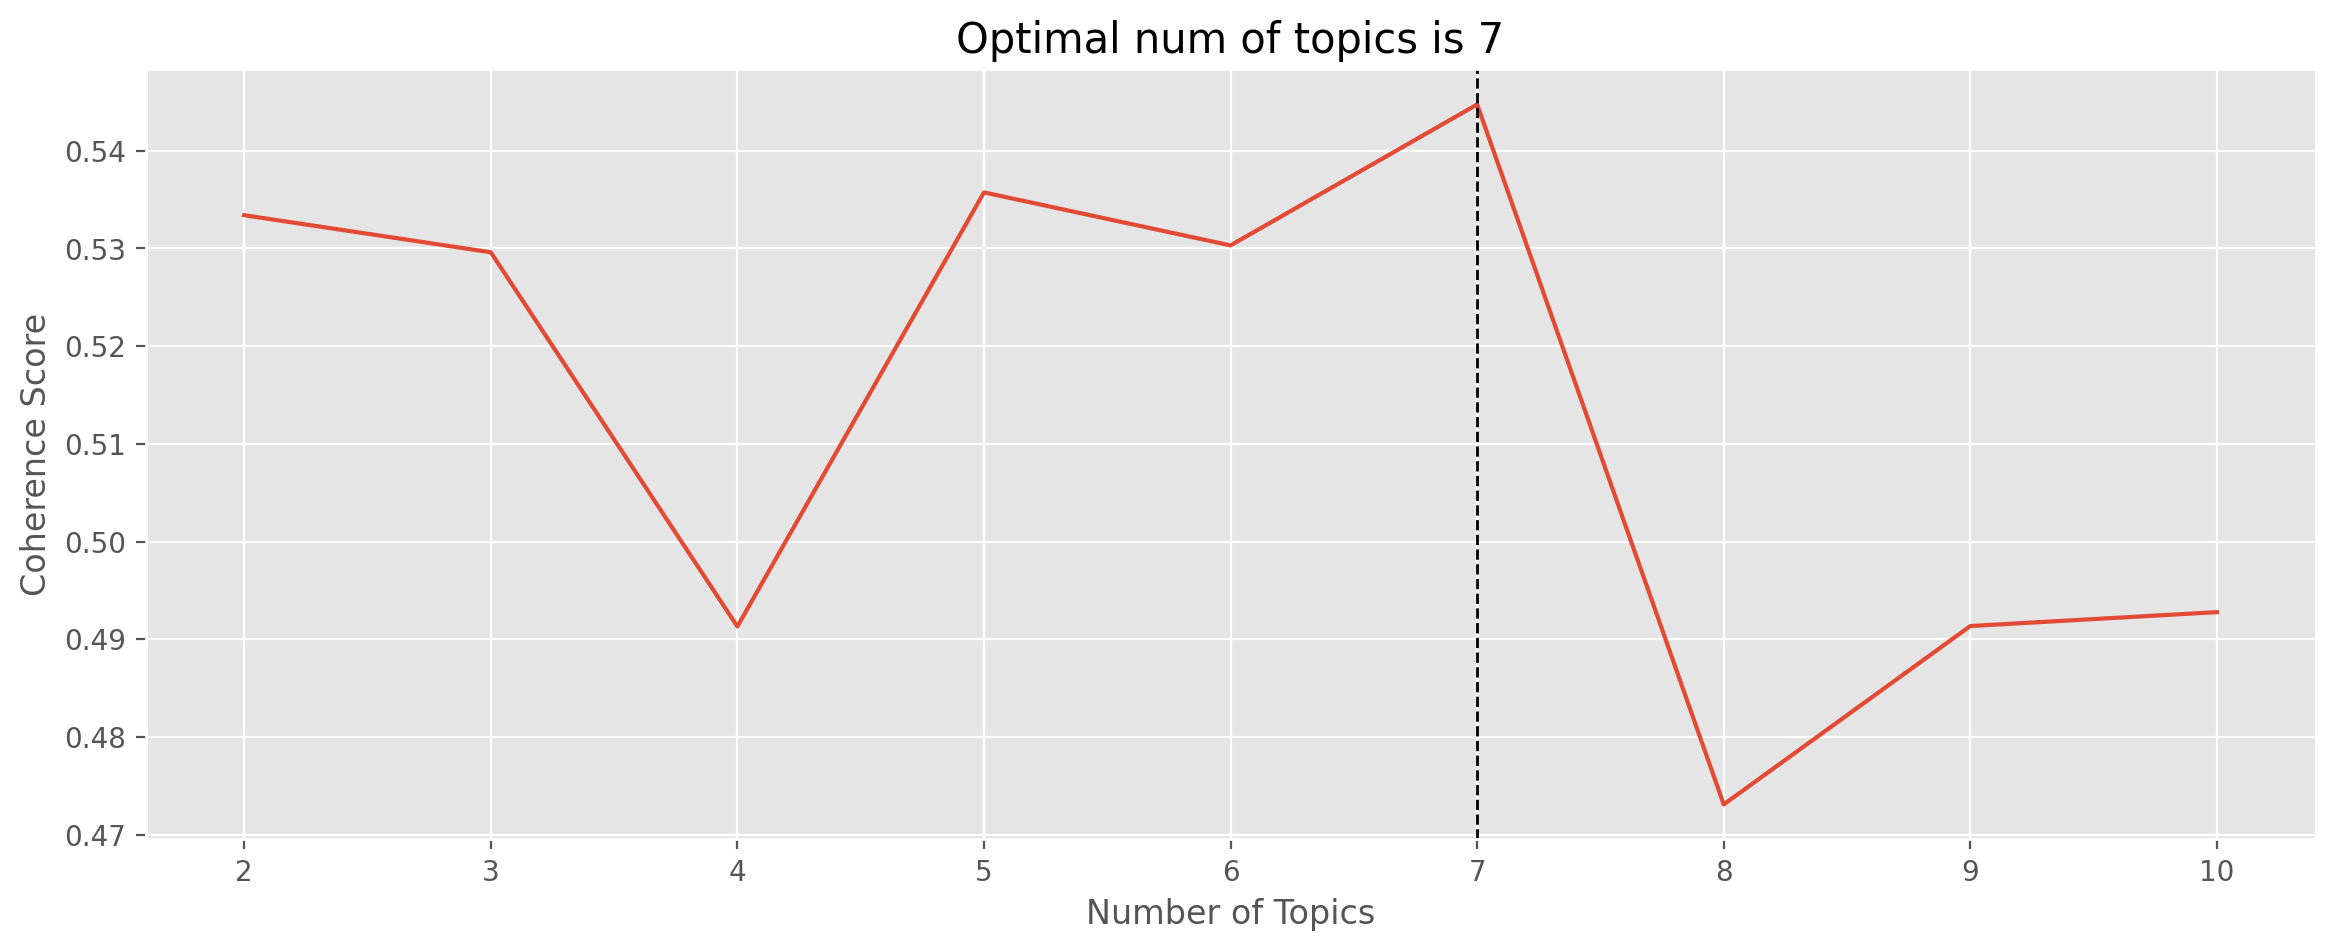

In [12]:
# plot the coherence scores
plt.figure(figsize=(14, 5), dpi=200)
plt.plot(topics_range, coherence_scores)
plt.axvline(x=optimal_num_topics, linestyle='--', color='black', linewidth=1)
plt.xticks(range(2, 11, 1))
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title(f'Optimal num of topics is {optimal_num_topics}', size=15)
plt.show()

**Note**
- The selection of number range of topics was driven by the fact that the coherence score pleateauing out after 10 when the range of topic number was set up to 20.
- Based on the grid search, an ideal number of topics for the reviews is 7. For this reason, this optimal number should be used for training LDA model. And since grid search involving number of topics has been done, hyperparameter tuning later will not need to include the same parameter anymore to save the time.

### **4.3 LDA Model Training**

In [13]:
# train LDA model
start_time = time.time()
lda_model = LdaModel(corpus=corpus,
                     num_topics=optimal_num_topics,
                     id2word=dictionary,
                     random_state=42,
                     passes=20)
end_time = time.time()
print(f'Time taken for model training: {end_time - start_time:.2f} seconds')

Time taken for model training: 80.27 seconds


In [14]:
# compute coherence score
untuned_coherence_model = CoherenceModel(model=lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
untuned_coherence_score = untuned_coherence_model.get_coherence()

# calculate perplexity
untuned_perplexity = lda_model.log_perplexity(corpus)
untuned_perplexity_value = np.exp(-untuned_perplexity)

# print output
print(f'Coherence score: {untuned_coherence_score:.4f}')
print(f'Perplexity: {untuned_perplexity_value:.4f}')

Coherence score: 0.5447
Perplexity: 1551.3549


**Note**
- The coherence score measures the degree of semantic similarity between high-scoring words in each topic. It ranges from 0 to 1, with higher scores indicating better topic quality. A score of 0.54 suggests that the topics are moderately coherent. This means that the words in each topic are somewhat related and can collectively convey a clear theme or meaning. This moderate coherence is normal since app reviews normally cover broad range of feedback. For example, a previous study, examining Indonesian reviews with LDA, shows that the range of coherence scores is between 0.37 and 0.42 (Annisa & Surjandari, [2019](https://doi.org/10.1016/j.procs.2019.11.178)).
- Perplexity is a measure of how well the probability distribution predicted by the model aligns with the observed data. Lower perplexity indicates a better fit to the data.

### **4.4 Hyperparameter Tuning**
In the [documentation]((https://radimrehurek.com/gensim/models/ldamodel.html)) of Gensim, there are plenty of parameters such as `passes`, `alpha`, `eta`, `iterations`, and `num_topics`, to name a few, can be specified for a Latent Dirichlet Allocation model. However, I decided to use `alpha` and `iterations` for hyperparameter tuning process. One main reason is due to the more parameters, the higher computational resource and training time involves. `num_topics` will not be utilized again since it has been used during grid search to obtain the optimal number of topics based on coherence score. 

In [15]:
# set hyperapram grid
param_grid = {
    'alpha': ['auto', 0.01, 0.1, 1.0],
    'iterations': [100, 200]
}

grid = ParameterGrid(param_grid)

**Note**: Above I set two parameters for grid search, namely `iterations` and `alpha`. `iterations` is concerned with how well the model converges to a stable solution. Insufficient iterations can lead to failure in capturing underlying structure of the data. One way to identify this issue is from the small topic coherence score. Second, I also set `alpha` which controls the distribution of topics per documents. A very low alpha value can cause the model to be overfitting and a very high value can lead to mixing too much topic (underfitting). Grid search attempts to search the best possible combination of parameters based on coherence score as the primary metric of evaluation in this project.

In [16]:
best_coherence = -1
best_params = {}

for params in grid:
    start_time = time.time()
    # train the LDA model
    tuned_lda_model = LdaModel(corpus=corpus,
                         num_topics=optimal_num_topics,
                         id2word=dictionary,
                         alpha=params['alpha'],
                         passes=20,
                         iterations=params['iterations'],
                         random_state=42)
    # calculate coherence score
    coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Params: {params}, coherence score: {coherence_score:.4f}, TT: {elapsed_time:.2f} seconds")

    # update the best score and parameters
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_params = params

print(f"Best coherence score: {best_coherence:.4f} with params: {best_params}")

Params: {'alpha': 'auto', 'iterations': 100}, coherence score: 0.5223, TT: 71.37 seconds
Params: {'alpha': 'auto', 'iterations': 200}, coherence score: 0.5197, TT: 72.66 seconds
Params: {'alpha': 0.01, 'iterations': 100}, coherence score: 0.5385, TT: 87.01 seconds
Params: {'alpha': 0.01, 'iterations': 200}, coherence score: 0.5235, TT: 87.78 seconds
Params: {'alpha': 0.1, 'iterations': 100}, coherence score: 0.5254, TT: 82.52 seconds
Params: {'alpha': 0.1, 'iterations': 200}, coherence score: 0.5269, TT: 81.02 seconds
Params: {'alpha': 1.0, 'iterations': 100}, coherence score: 0.5170, TT: 73.12 seconds
Params: {'alpha': 1.0, 'iterations': 200}, coherence score: 0.5170, TT: 72.97 seconds
Best coherence score: 0.5385 with params: {'alpha': 0.01, 'iterations': 100}


In [17]:
# train LDA model w/ opt param
start_time = time.time()
tuned_lda_model = LdaModel(corpus=corpus,
                     num_topics=optimal_num_topics,
                     id2word=dictionary,
                     random_state=42,
                     alpha=0.01,
                     iterations=100,
                     passes=20)
end_time = time.time()
print(f'Time taken for model training: {end_time - start_time:.2f} seconds')

Time taken for model training: 88.34 seconds


In [18]:
# compute coherence score
tuned_coherence_model = CoherenceModel(model=tuned_lda_model, texts=df4['tokens'],
                                 dictionary=dictionary, coherence='c_v')
tuned_coherence_score = tuned_coherence_model.get_coherence()

# calculate perplexity
tuned_perplexity = tuned_lda_model.log_perplexity(corpus)
tuned_perplexity_value = np.exp(-tuned_perplexity)

# print output
print(f'Coherence score: {tuned_coherence_score:.4f}')
print(f'Perplexity: {tuned_perplexity_value:.4f}')

Coherence score: 0.5385
Perplexity: 3451.5665


### **4.5 Evaluation and Explanation**

#### **3.5.1 Model Comparison**

In [19]:
# model comparison
pd.DataFrame({
    'Metric': ['UntunedCoherenceScore', 'UntunedPerplexity', 'TunedCoherenceScore', 'TunedPerplexity'],
    'Score': [untuned_coherence_score, untuned_perplexity_value, tuned_coherence_score, tuned_perplexity_value],
}).round(2)

,Metric,Score
0,UntunedCoherenceScore,0.54
1,UntunedPerplexity,1551.35
2,TunedCoherenceScore,0.54
3,TunedPerplexity,3451.57


**Note**: As the tuned LDA model has better performance based on coherence and perplexity scores, the tuned version will be selected for topic extraction and model explanation. After hyperparameter tuning, the perplexity score increased significantly by 1900 while the coherence score after tuning does not show a significant changes. For this reason, the original model is selected for topic extraction and evaluation.

#### **4.5.2 Topic Extraction**

In [25]:
# display the top 10 words for each topic
for idx, topic in lda_model.show_topics(num_topics=optimal_num_topics, num_words=10, formatted=False):
    print(f"Topic {idx}: {[word for word, _ in topic]}")

Topic 0: ['gopay', 'top', 'aplikasi', 'up', 'pake', 'saldo', 'fiturnya', 'terbaik', 'dah', 'download']
Topic 1: ['bagus', 'mantap', 'good', 'aplikasi', 'aplikasinya', 'mantab', 'gopay', 'memuaskan', 'job', 'jos']
Topic 2: ['membantu', 'gopay', 'aplikasi', 'bayar', 'pulsa', 'gojek', 'beli', 'pembayaran', 'pinjam', 'pakai']
Topic 3: ['transfer', 'mudah', 'ribet', 'aplikasi', 'bank', 'gratis', 'gampang', 'gopay', 'aplikasinya', 'biaya']
Topic 4: ['transaksi', 'keren', 'mudah', 'semoga', 'gopay', 'aplikasi', 'kasih', 'cepat', 'memudahkan', 'bintang']
Topic 5: ['gopay', 'kota', 'aplikasi', 'udah', 'tolong', 'coba', 'masuk', 'akun', 'terimakasih', 'saldo']
Topic 6: ['banget', 'ok', 'aplikasi', 'suka', 'fitur', 'bgt', 'mempermudah', 'lengkap', 'gopay', 'bertransaksi']


**Note**
- **Topic 0**: This topic may be about user satisfaction with GoPay and its features (like top-up, saldo, and best features), indicating discussions about using the GoPay app and topping up balances.
- **Topic 1**: This topic revolves around positive feedback or praise, with words like "bagus" (good), "mantap" (great), and "memuaskan" (satisfying). Users are likely expressing their high satisfaction with GoPay.
- **Topic 2**: This topic seems focused on utility and transactions. Users are discussing payments, buying pulsa (phone credit), using GoPay for purchases, and the app being helpful.
- **Topic 3**: This topic is related to transfers and the ease of using the app for transferring money between banks. Words like "mudah" (easy), "gratis" (free), and "biaya" (fees) suggest discussions about convenience and cost.
- **Topic 4**: This topic covers transactions and ease of use, with users likely praising the speed and efficiency of transactions through the app, with hopes for continued good service.
- **Topic 5**: This topic may reflect issues with logging in or account access. Words like "masuk" (enter), "akun" (account), and "tolong" (help) suggest users may be asking for help with accessing their accounts.
- **Topic 6**: This topic emphasizes general satisfaction with the app, specifically around features and how it simplifies transactions. Words like "mempermudah" (simplifies) and "lengkap" (complete) suggest users are happy with the range of services.
- Words like "aplikasi" (application) and "gopay" appear across multiple topics because they're central to the app. This is common in LDA, as some general words are used broadly.
- Several topics (e.g., Topic 1, Topic 4) show that users are expressing positive sentiments.
- Topics 2, 3, and 5 discuss how users interact with GoPay, focusing on transactions, ease of use, and occasional issues (usability).

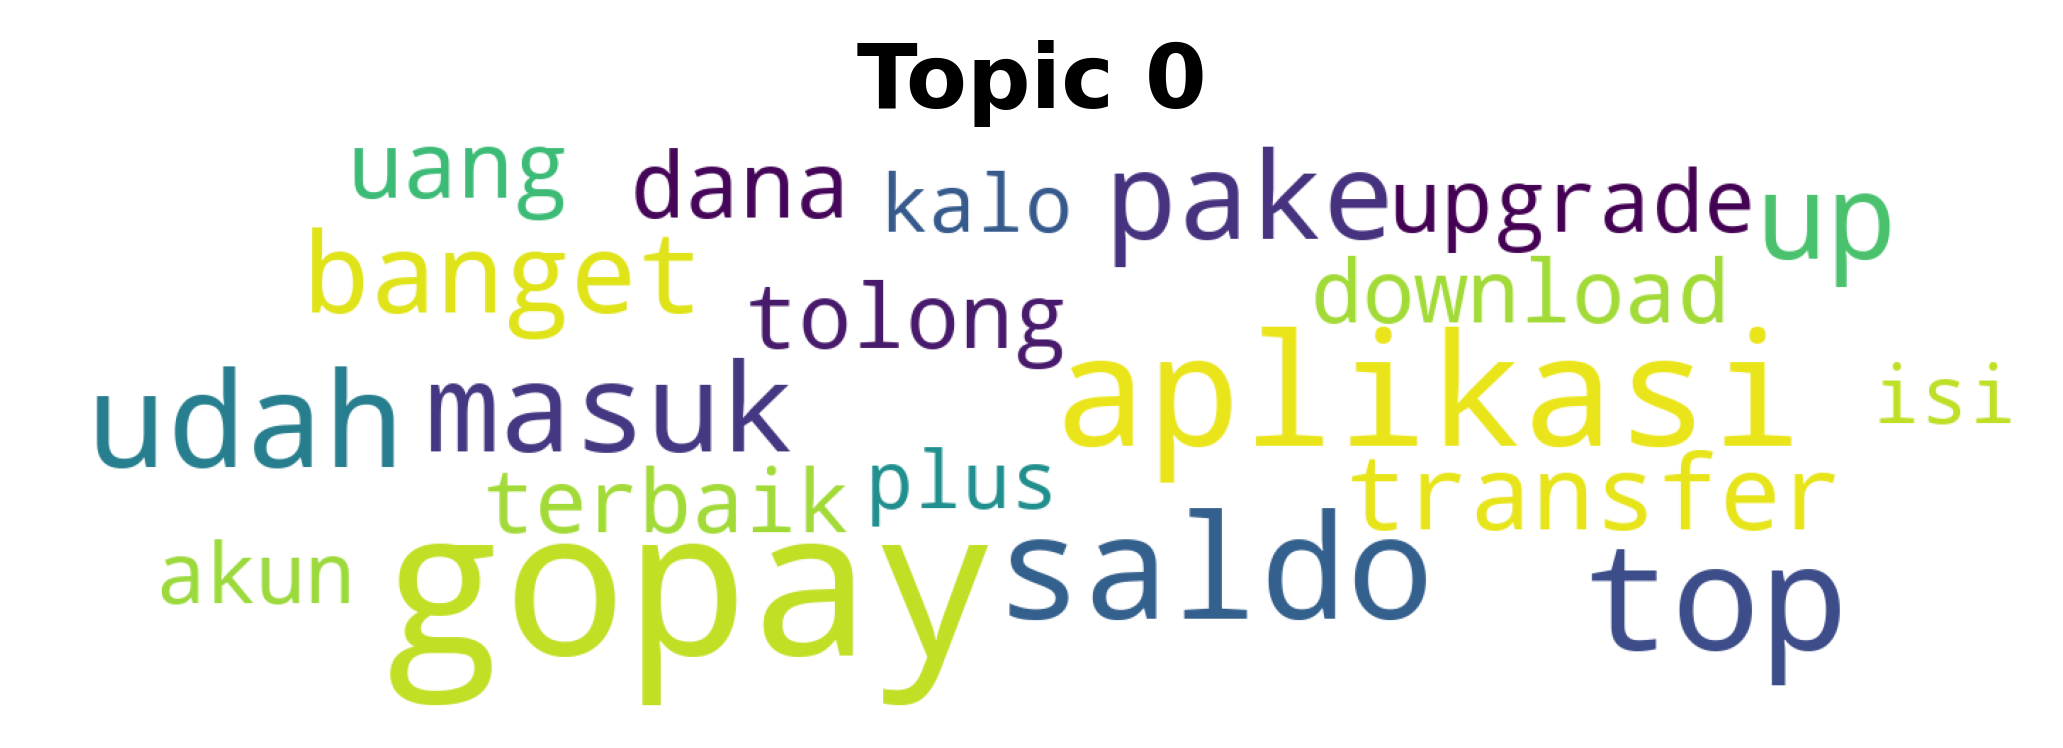

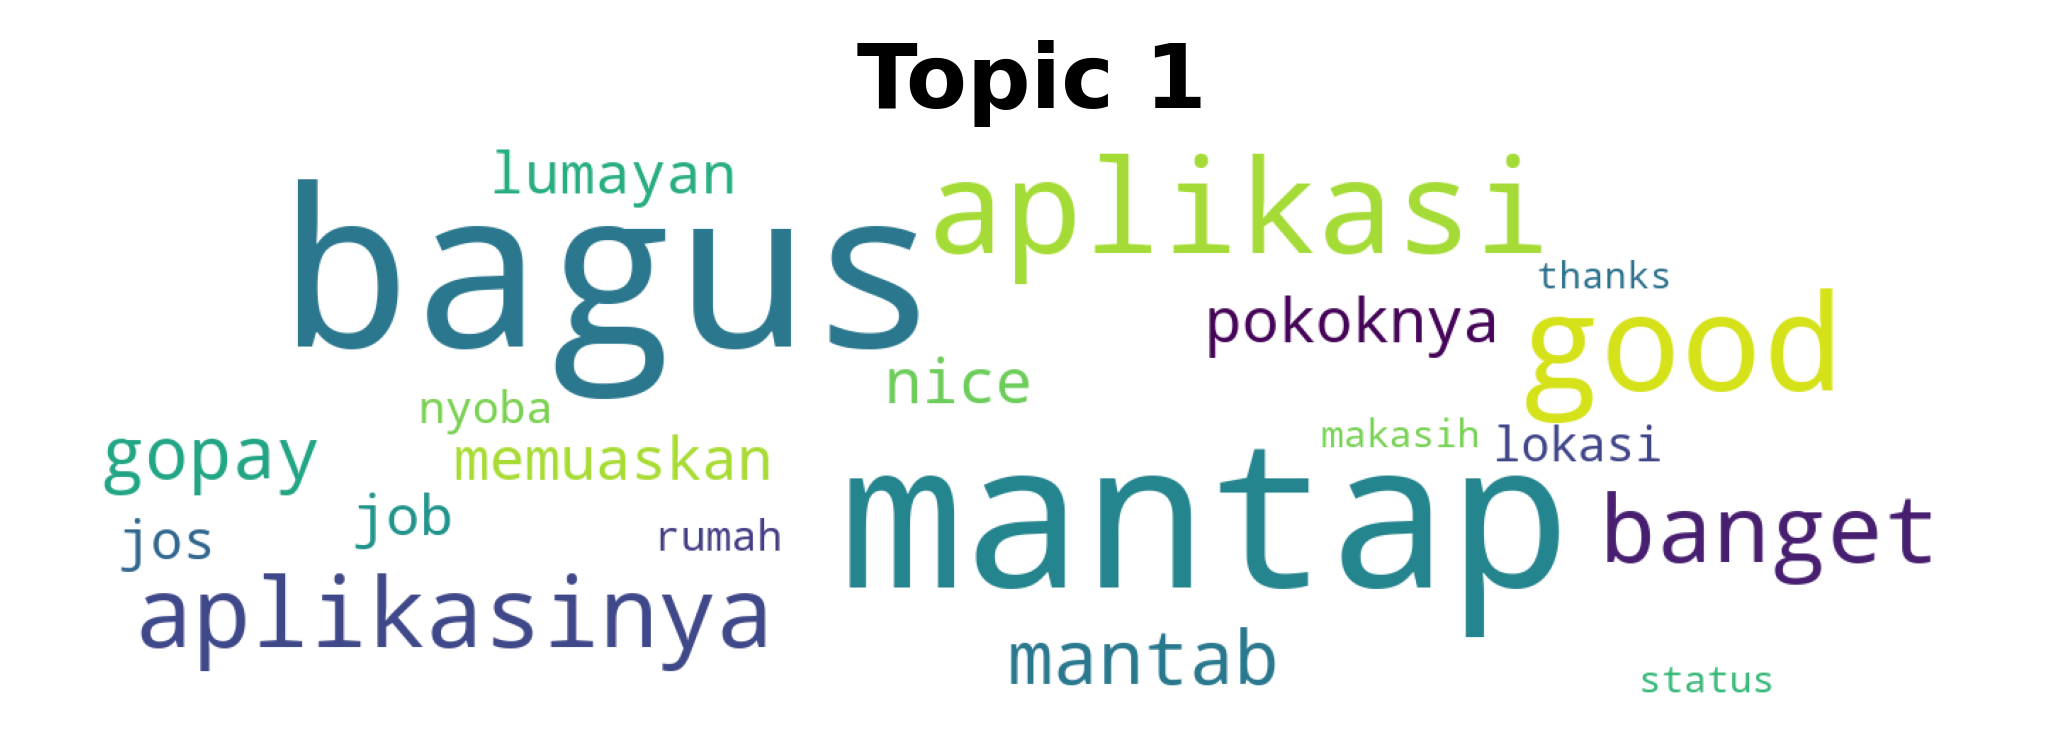

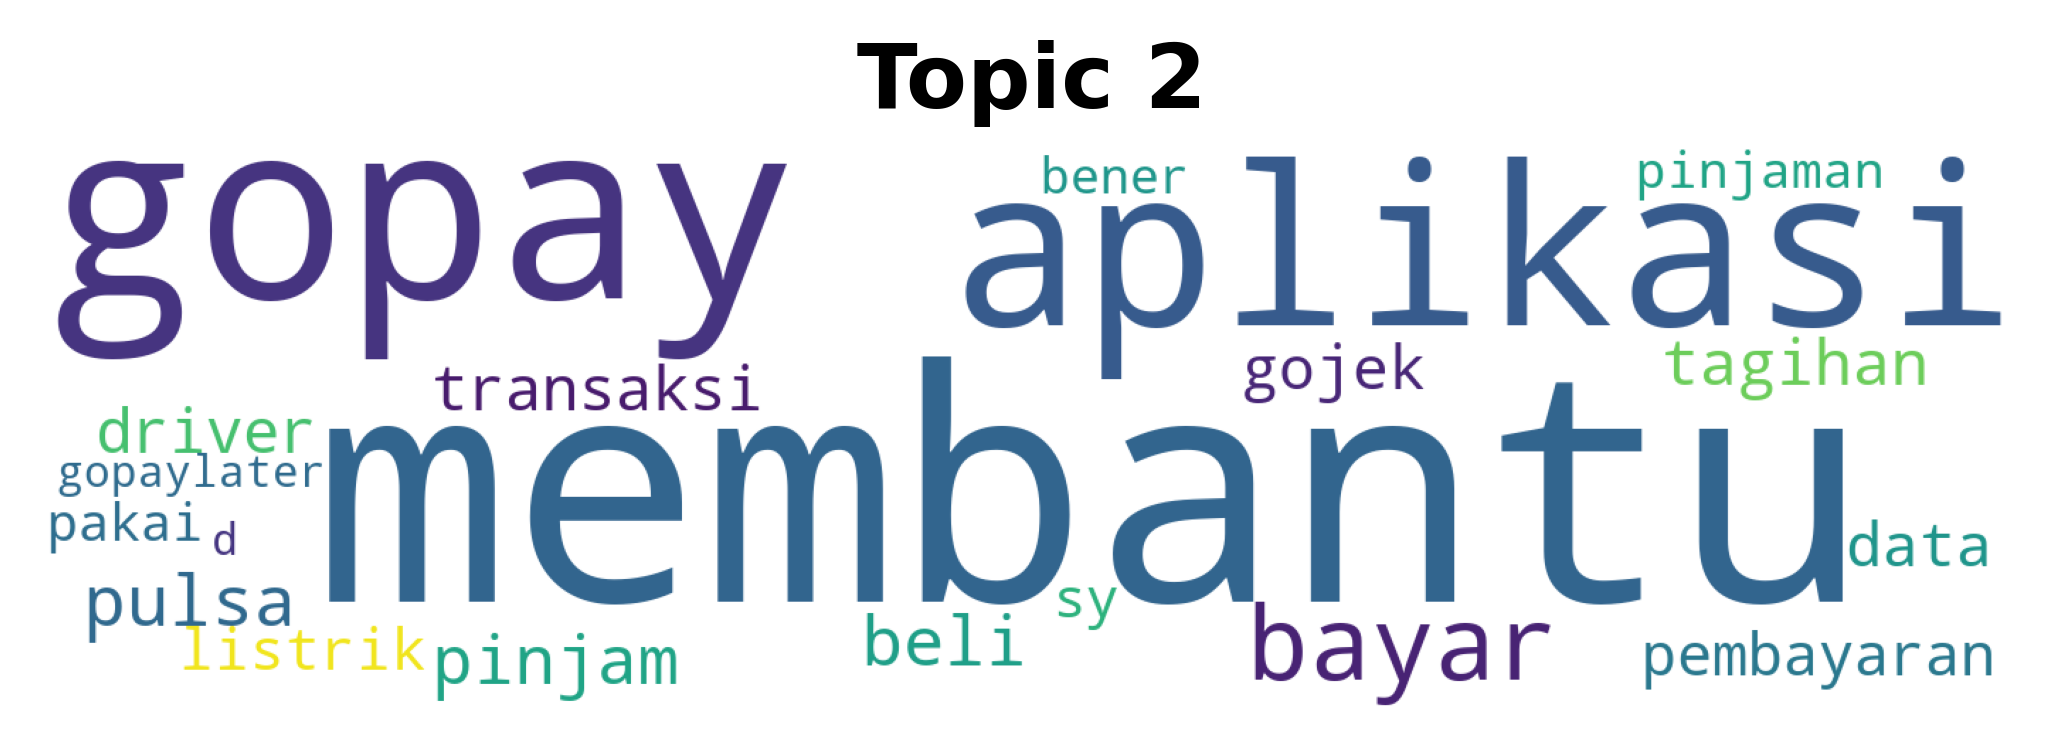

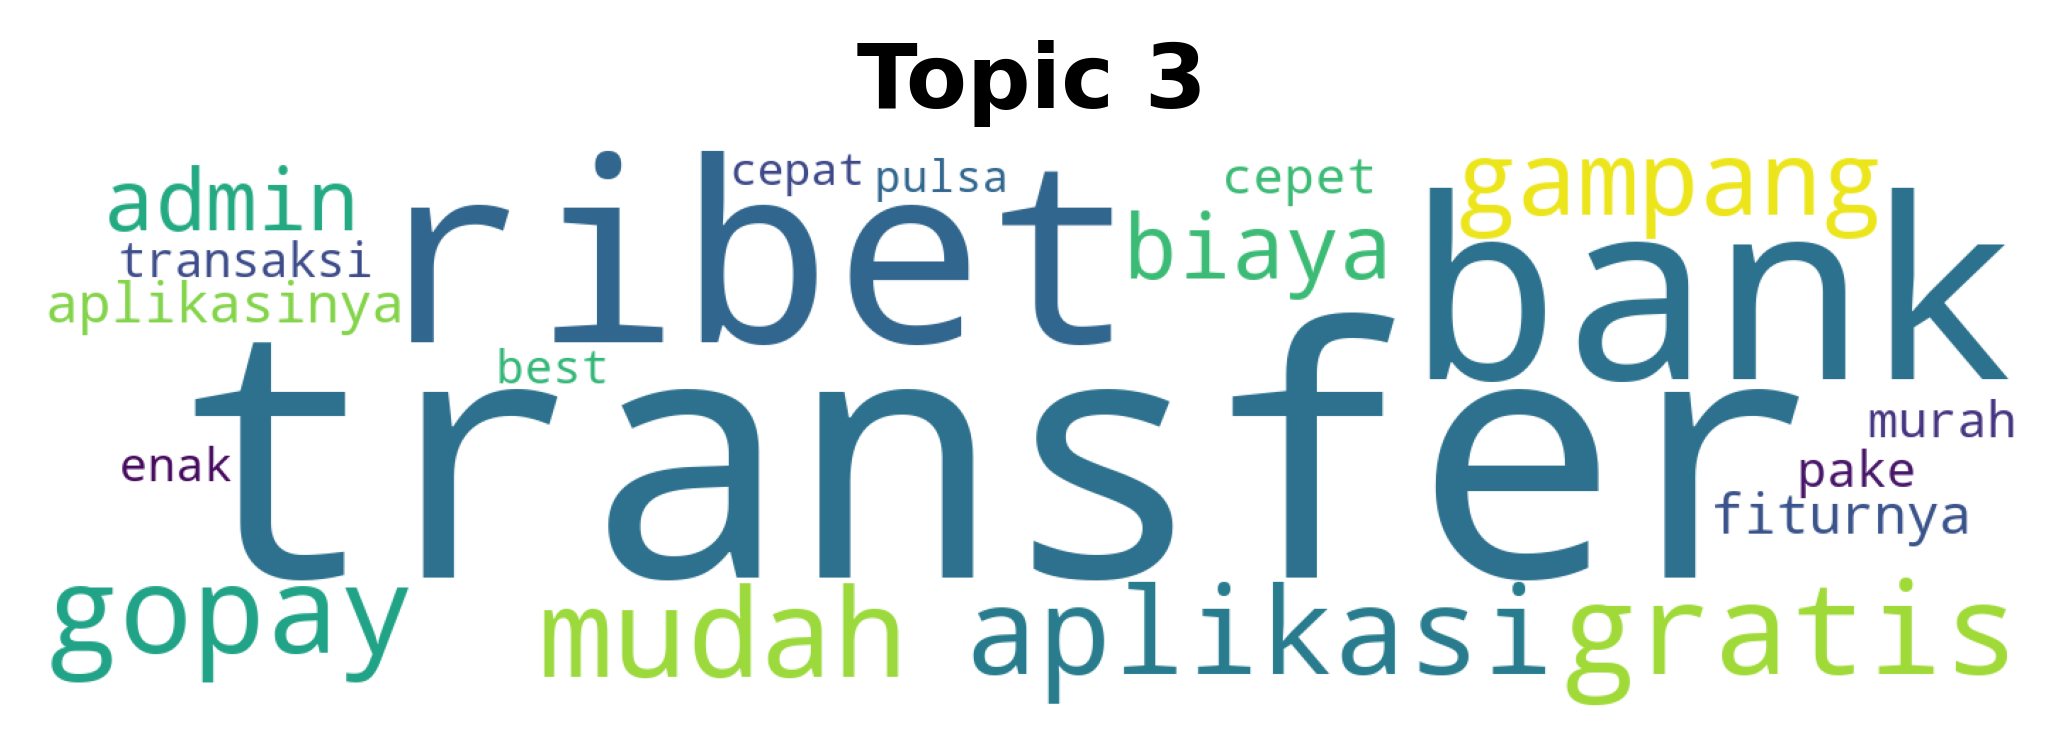

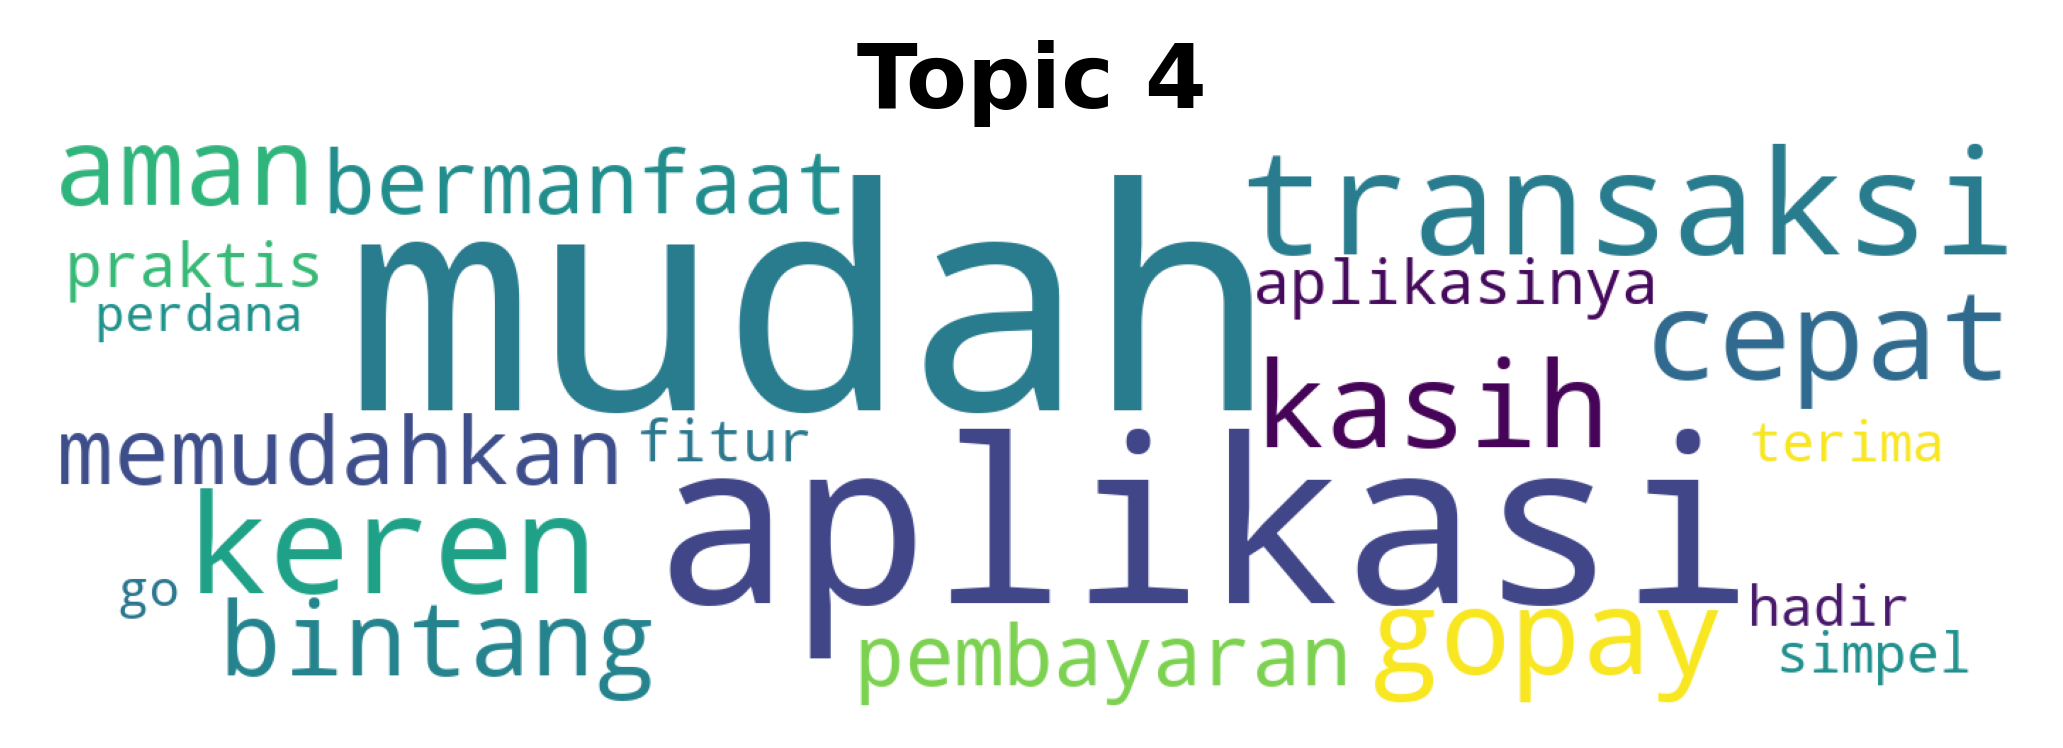

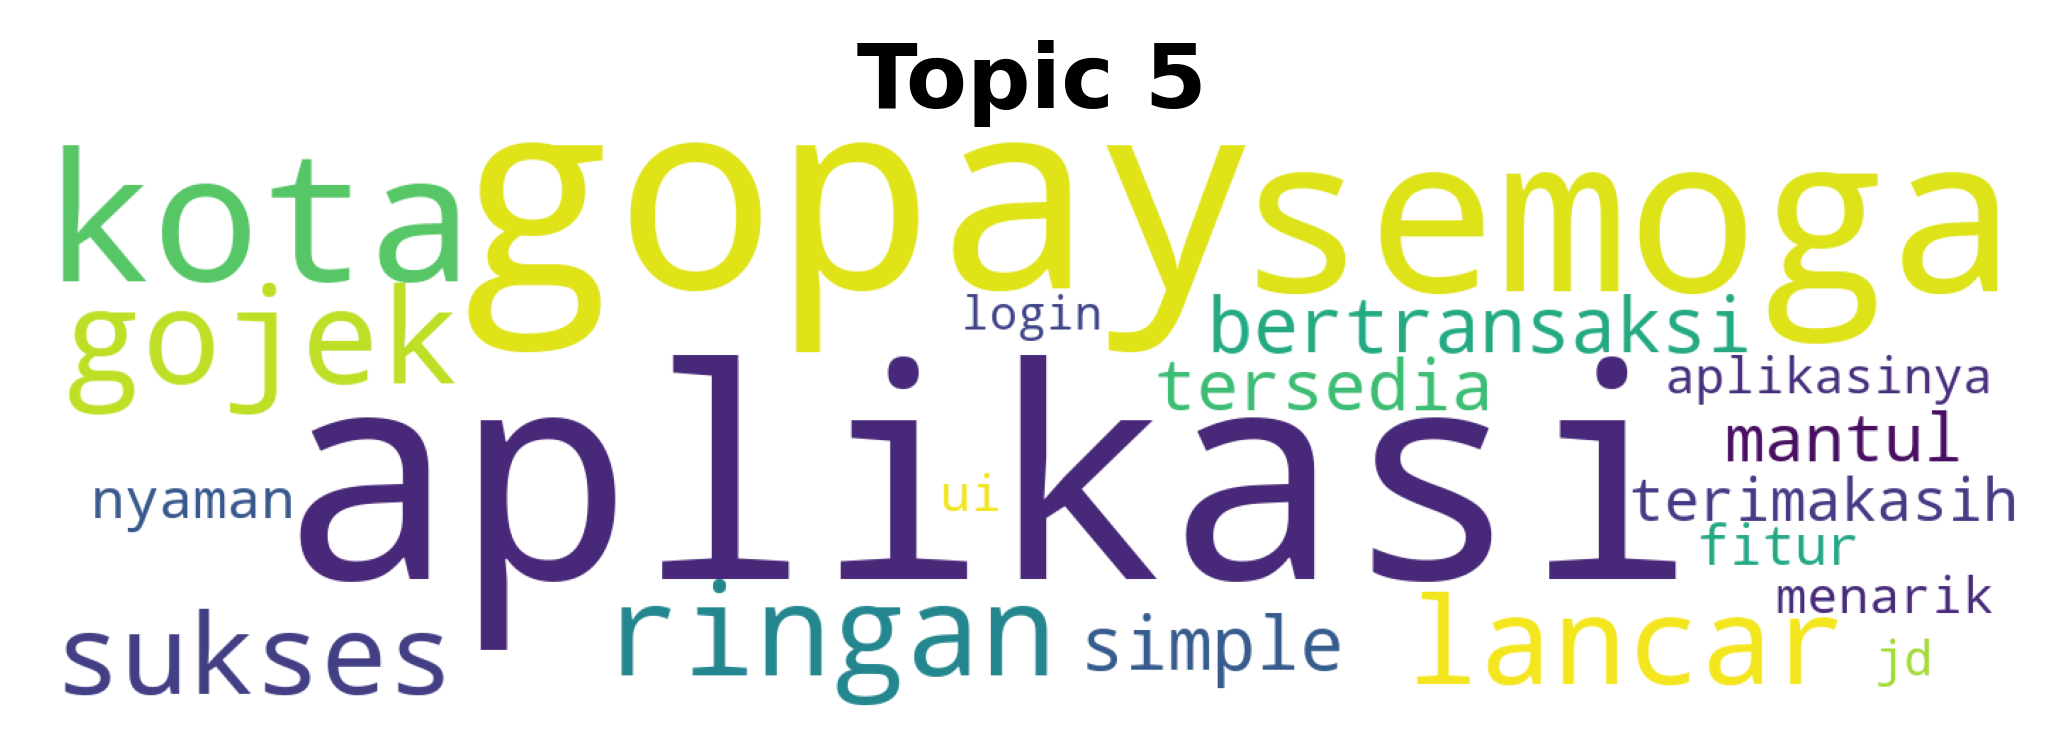

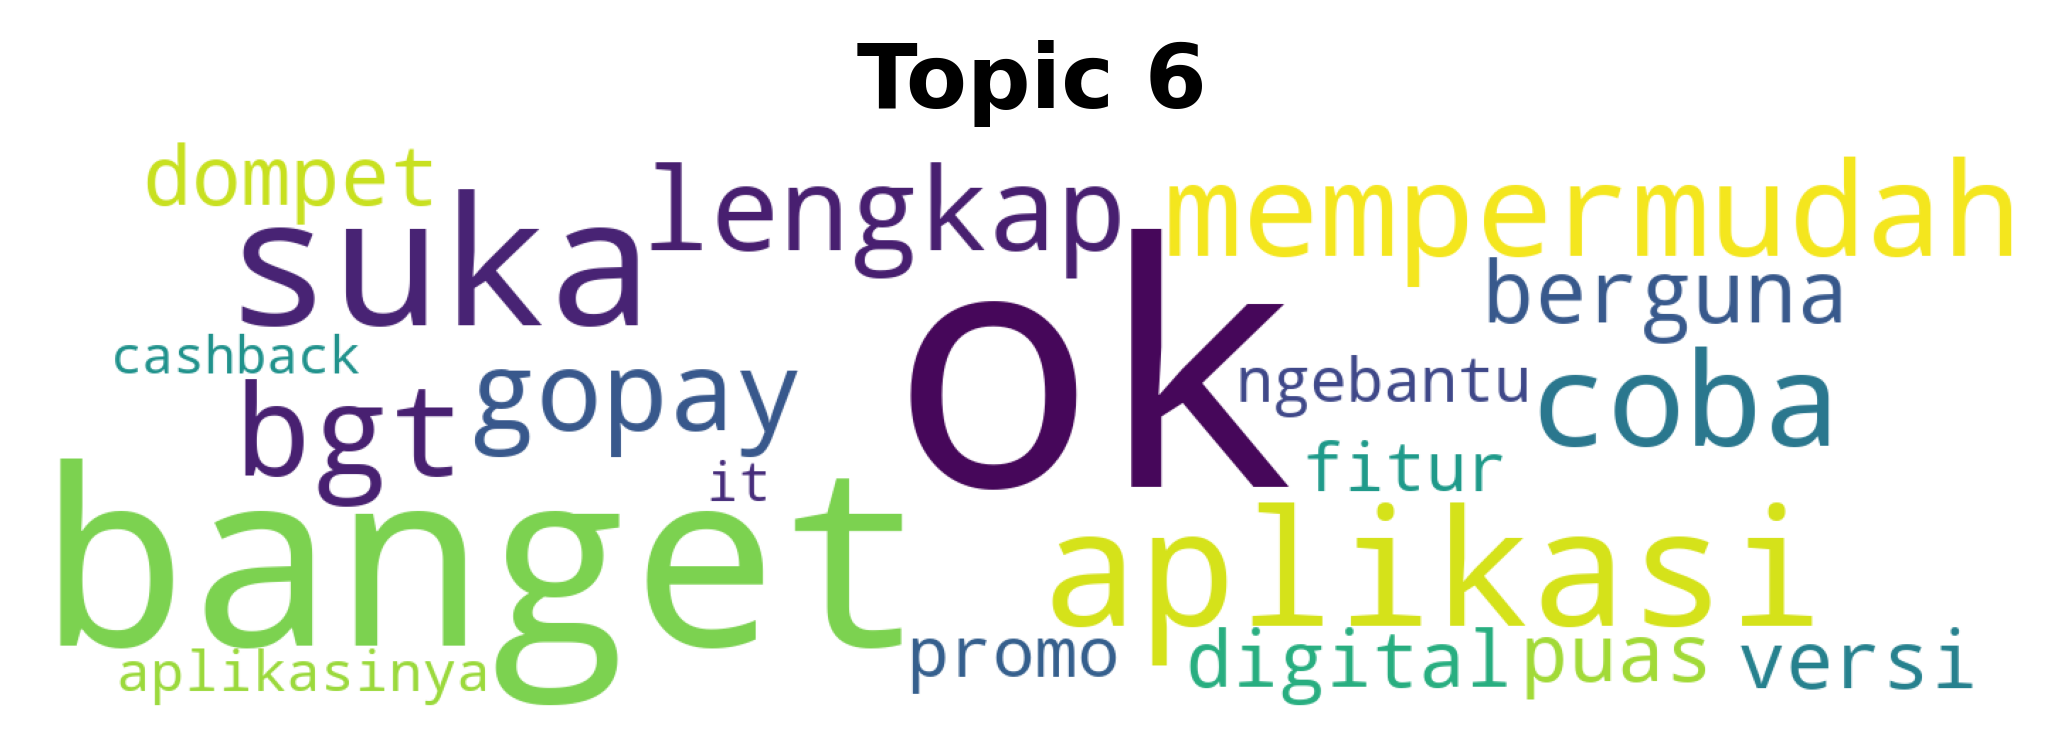

In [26]:
# generate word clouds for each topic
for idx in range(tuned_lda_model.num_topics):
    plt.figure(dpi=400)  # Increased DPI
    wordcloud = (WordCloud(width=1400, height=400, background_color='white', prefer_horizontal=1.0)
                .fit_words(dict(tuned_lda_model.show_topic(idx, topn=20)))
    )

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Topic {idx}', size=16, weight='bold')
    plt.show()

#### **4.5.3 Topic Distribution**

In [20]:
# init topics with default value
df4['topic'] = -1

# loop over each document and assign the most probable topic
for i, doc_bow in enumerate(corpus):
    if doc_bow:  
        topic_assignment = tuned_lda_model.get_document_topics(doc_bow)
        if topic_assignment:
            df4.at[i, 'topic'] = max(topic_assignment, key=lambda x: x[1])[0]

display(df4.head())

,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,tokens,topic
0,Pengguna Google,Mantap,5,0,1.24.1,2024-07-07 16:58:06,[mantap],1
1,Pengguna Google,Bagus dan mudah digunakan,5,0,1.24.1,2024-07-07 16:57:08,"[bagus, mudah]",1
2,Pengguna Google,Good,5,0,1.24.1,2024-07-07 16:52:38,[good],1
3,Pengguna Google,Sangat membantu orang menengah mantap semoga sukses terus gopay,5,0,1.24.1,2024-07-07 16:52:36,"[membantu, orang, menengah, mantap, semoga, sukses, gopay]",2
4,Pengguna Google,Ga ribet .. Sukaaaa,5,0,1.24.1,2024-07-07 16:52:09,"[ribet, suka]",3


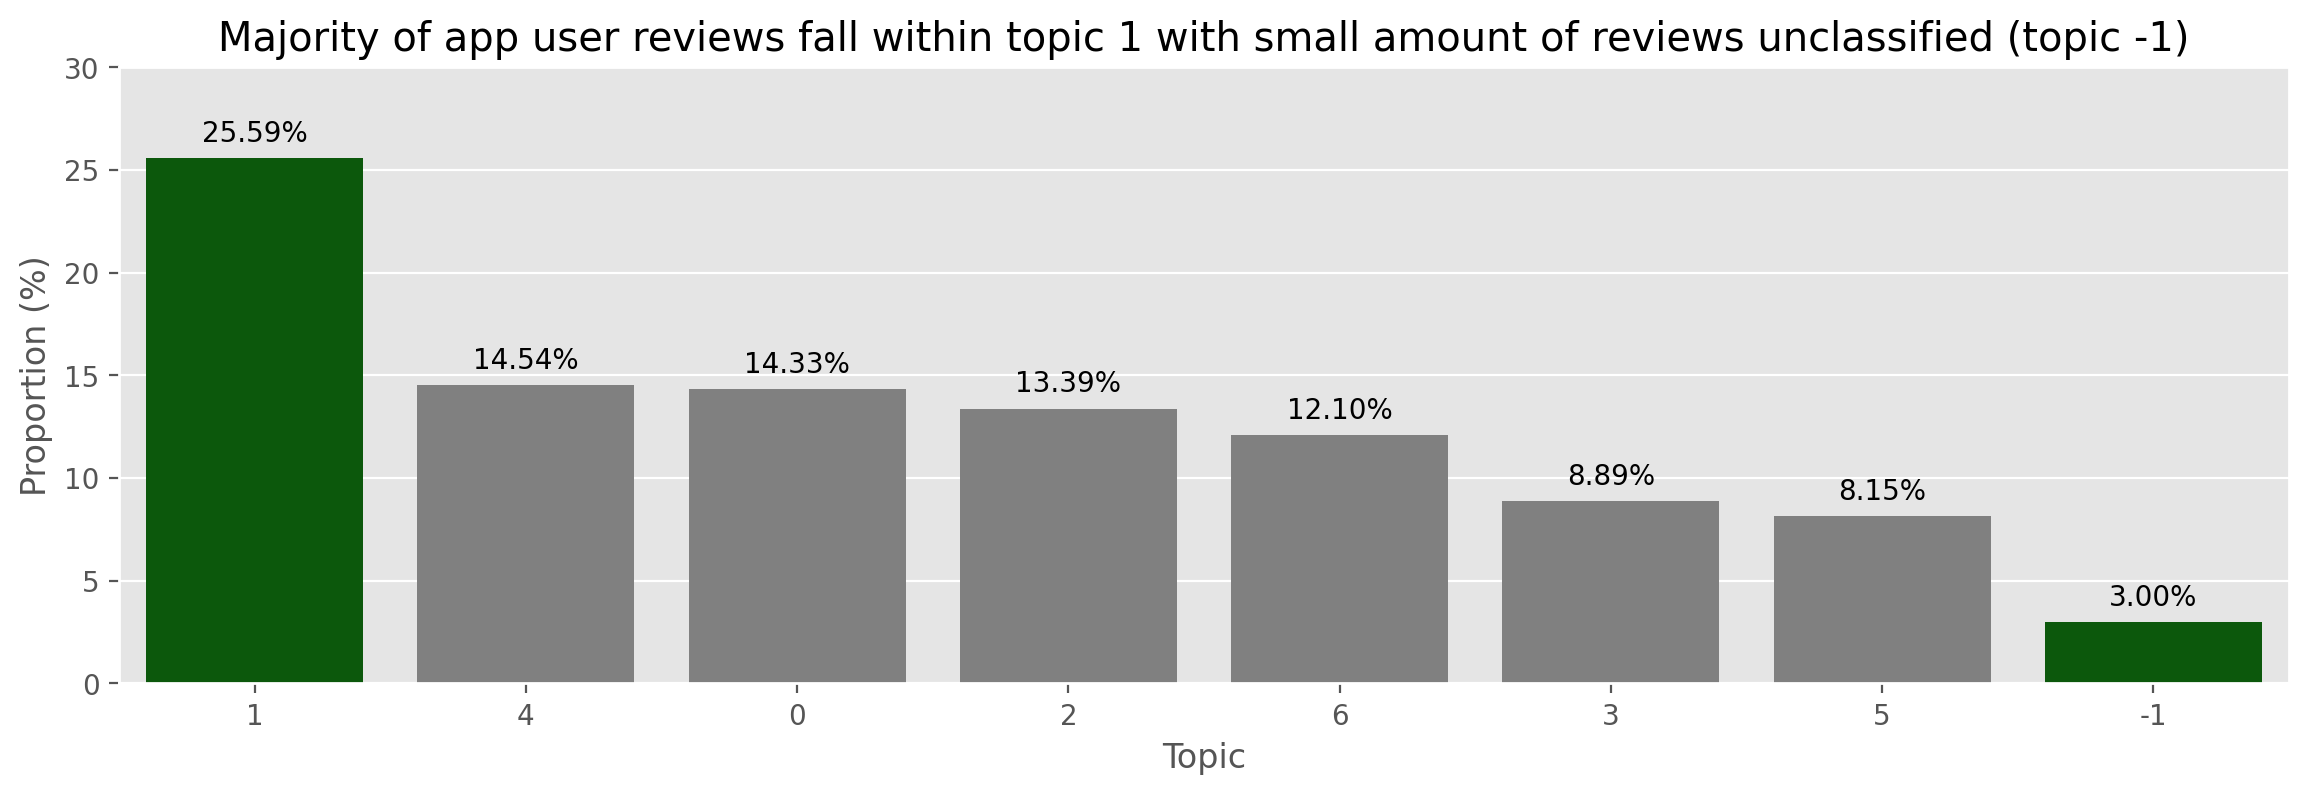

In [21]:
# prepare data
topic_proportion = (df4['topic'].value_counts(normalize=True)*100).reset_index().round(2)
topic_proportion['topic'] = topic_proportion['topic'].astype(str)
topic_proportion = topic_proportion.sort_values(by='proportion', ascending=False)

# set figure size
plt.figure(figsize=(14, 4), dpi=200)

# highlight topic 1 and 4
highlight_colors = ['darkgreen' if topic in ['1', '-1'] else 'grey' for topic in topic_proportion['topic']]

# make bar chart
sns.barplot(y='proportion', x='topic', data=topic_proportion, hue='topic',
            palette=highlight_colors)

for index, row in topic_proportion.iterrows():
    plt.text(row.name, row['proportion'] + 0.5, f'{row["proportion"]:.2f}%', 
             ha='center', va='bottom', fontsize=10)
plt.yticks(range(0,35,5))
plt.title('Majority of app user reviews fall within topic 1 with small amount of reviews unclassified (topic -1)')
plt.xlabel('Topic')
plt.ylabel('Proportion (%)')
plt.show()

**Note**: The bar chart summarizes the distribution of the 7 topics plus the unclassified reviews (Topic -1). In short, the majority of user reviews can be classified into Topic 1, discussing about positive feedback on the app. Only 3% of the reviews cannot be classified into any topics generated by the LDA model. This small amount of unclassified reviews is normal in LDA. This might be a number of factors and I will keep the discussion in the following section.

In [22]:
# prepare data
topic_distribution = np.zeros((len(df4), tuned_lda_model.num_topics))
for i, item in enumerate(corpus):
    if item:
        topic_info = lda_model.get_document_topics(item)
        for topic_id, prob in topic_info:
            topic_distribution[i, topic_id] = prob

topic_df = pd.DataFrame(topic_distribution,
                        columns=[f'Topic {i}' for i in range(tuned_lda_model.num_topics)])

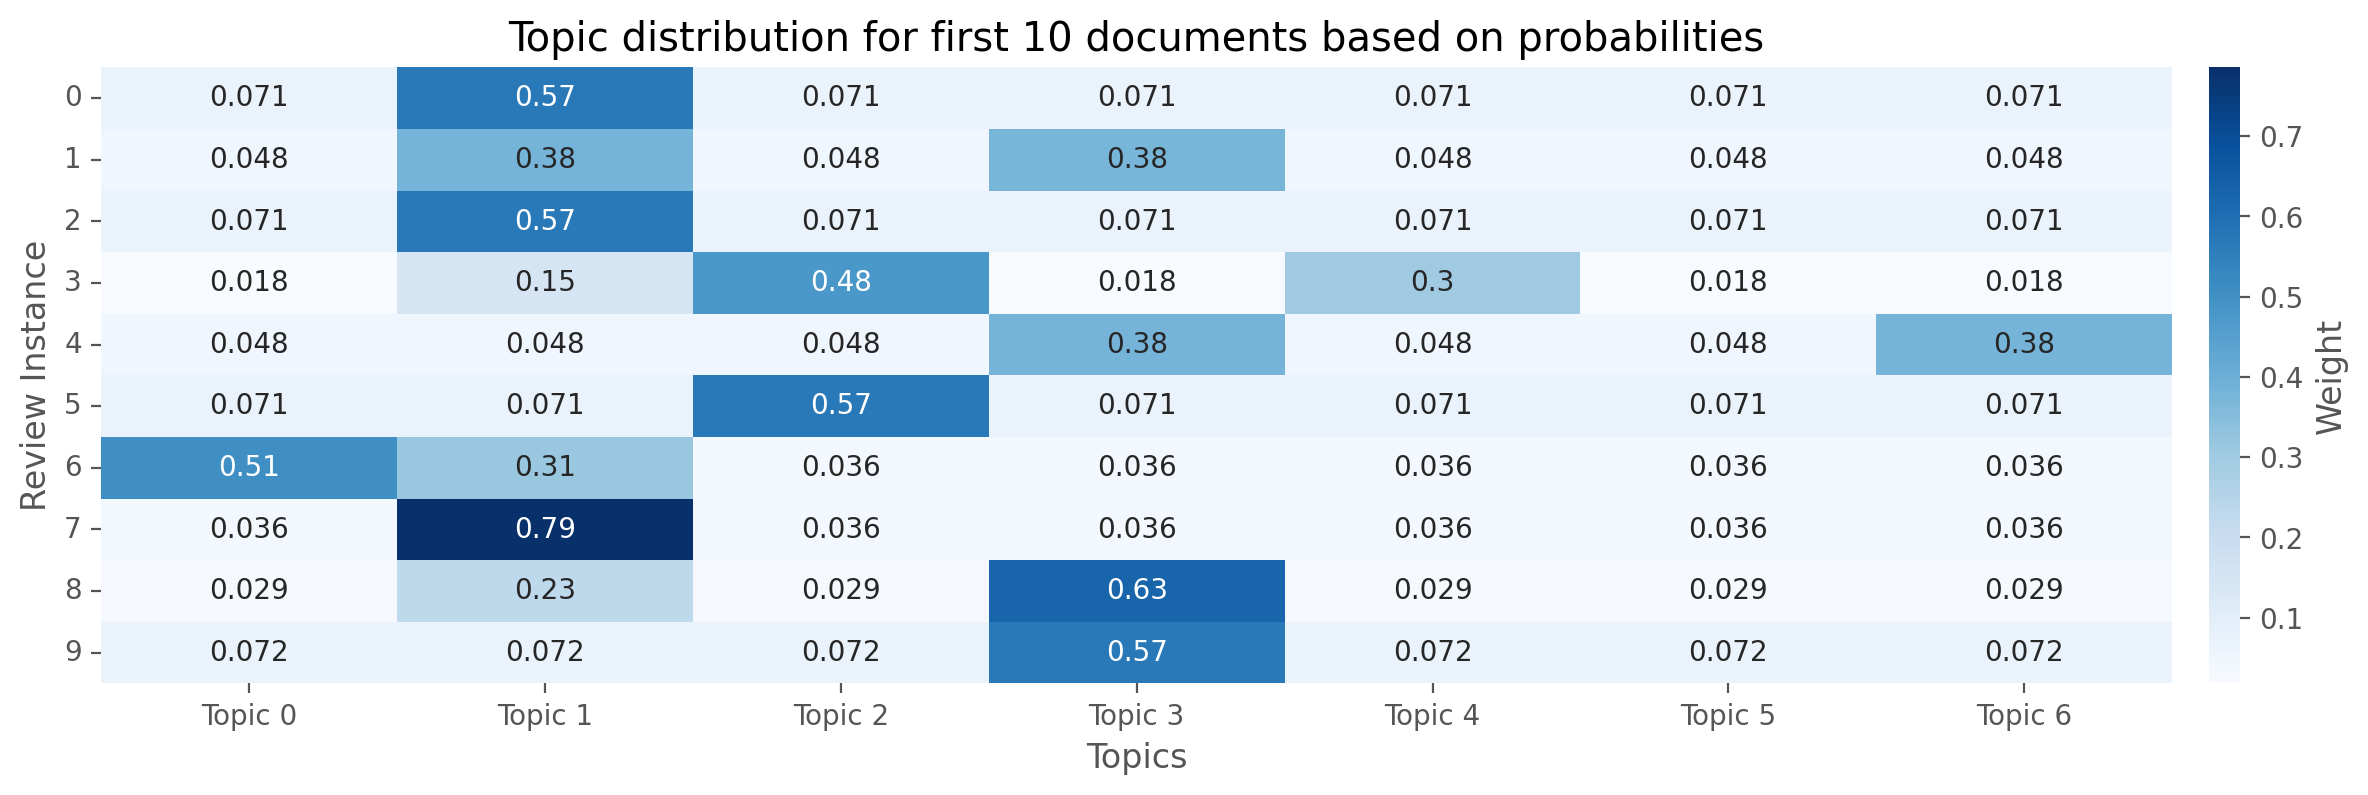

In [23]:
# visualize topic distribution for top-10 instance
plt.figure(figsize=(16, 4), dpi=200)
sns.heatmap(topic_df.iloc[:10], cmap='Blues', annot=True, cbar_kws={'label': 'Weight', 'pad': 0.015})
plt.title('Topic distribution for first 10 documents based on probabilities')
plt.ylabel('Review Instance')
plt.xlabel('Topics')
plt.yticks(rotation=0)
plt.show()

**Note**: The heatmap displays the distribution of topics in the snippet of the dataframe. In general, the heatmap answers why an individual review was attributed a certain topic by the LDA model. For example, review 1 in which a user said, "Mantap" (*Good*, see below) only was classified into Topic 1 which is concerned about positive feedback about the app. 

In [24]:
# show dataset
df4.iloc[:5, [1,6,7]]

,content,tokens,topic
0,Mantap,[mantap],1
1,Bagus dan mudah digunakan,"[bagus, mudah]",1
2,Good,[good],1
3,Sangat membantu orang menengah mantap semoga sukses terus gopay,"[membantu, orang, menengah, mantap, semoga, sukses, gopay]",2
4,Ga ribet .. Sukaaaa,"[ribet, suka]",3


##### **4.5.3.1 Why were some instances unclassified into certain topics?**
Some instances can be unclassified due to a number of reasons such as topic overlap (mixture of terms from different topics), short document length (not enough information to infer the topic group), and model limitation (not the best model). The first and second points can be tested directly in this notebook whereas for the last point, I need to compare different topic models to understand whether the small amount of unclassified reviews is due to the limitation of Latent Dirichlet Allocation. For the overlap between topics, I can investigate it by firstly checking whether there are terms present in different topics. If not found, I will test the potential overlapping topics by using cosine similarity.

In [25]:
# combine df4 and topic_df for probabilities
combined_df = pd.concat([df4.reset_index(drop=True), topic_df], axis=1)

In [26]:
# filter the combined dataframe for the unclassified instances
filtered_columns = ['content', 'tokens', 'topic'] + [f'Topic {i}' for i in range(tuned_lda_model.num_topics)]
unclassified_ins = combined_df[combined_df['topic'] == -1].copy() 
unclassified_ins_filtered = unclassified_ins[filtered_columns]

# display the filtered dataframe
columns = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']
print(f'Number of unclassified reviews: {len(unclassified_ins_filtered)}')
unclassified_ins_filtered.iloc[:5, :].style.background_gradient(cmap='YlOrRd', subset=columns)

Number of unclassified reviews: 3694


,content,tokens,topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
119559,"Jujur nih ya tampilan nya jelek banget asli dah 😗, teks nya juga alay","['jujur', 'tampilan', 'jelek', 'banget', 'asli', 'dah', 'teks', 'alay']",-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
119560,"Aplikasinya sangat bagus, sebagai pengguna gopay ini sangat membantu banget untuk saya","['aplikasinya', 'bagus', 'pengguna', 'gopay', 'membantu', 'banget']",-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
119561,Apk yang bermanfaat untuk menyimpan uang dan melakukan pembayaran banyak fitur-fitur yang menarik,"['aplikasi', 'bermanfaat', 'menyimpan', 'uang', 'pembayaran', 'fitur', 'fitur', 'menarik']",-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
119562,Aplikasi nya rekomended banget terus kalo mau beli pulsa maupun pake data juga mudah terus kalo mau tf uang juga ngg ada biaya mantab de pkonya,"['aplikasi', 'rekomended', 'banget', 'kalo', 'beli', 'pulsa', 'pake', 'data', 'mudah', 'kalo', 'transfer', 'uang', 'ngg', 'biaya', 'mantab', 'de', 'pkonya']",-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
119563,"Aplikasinya bermanfaat,fitur mudah dipahami,transaksi gratiss .","['aplikasinya', 'bermanfaat', 'fitur', 'mudah', 'dipahami', 'transaksi', 'gratiss']",-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
# add review len
unclassified_ins['review_len'] = unclassified_ins['content'].str.split().str.len()

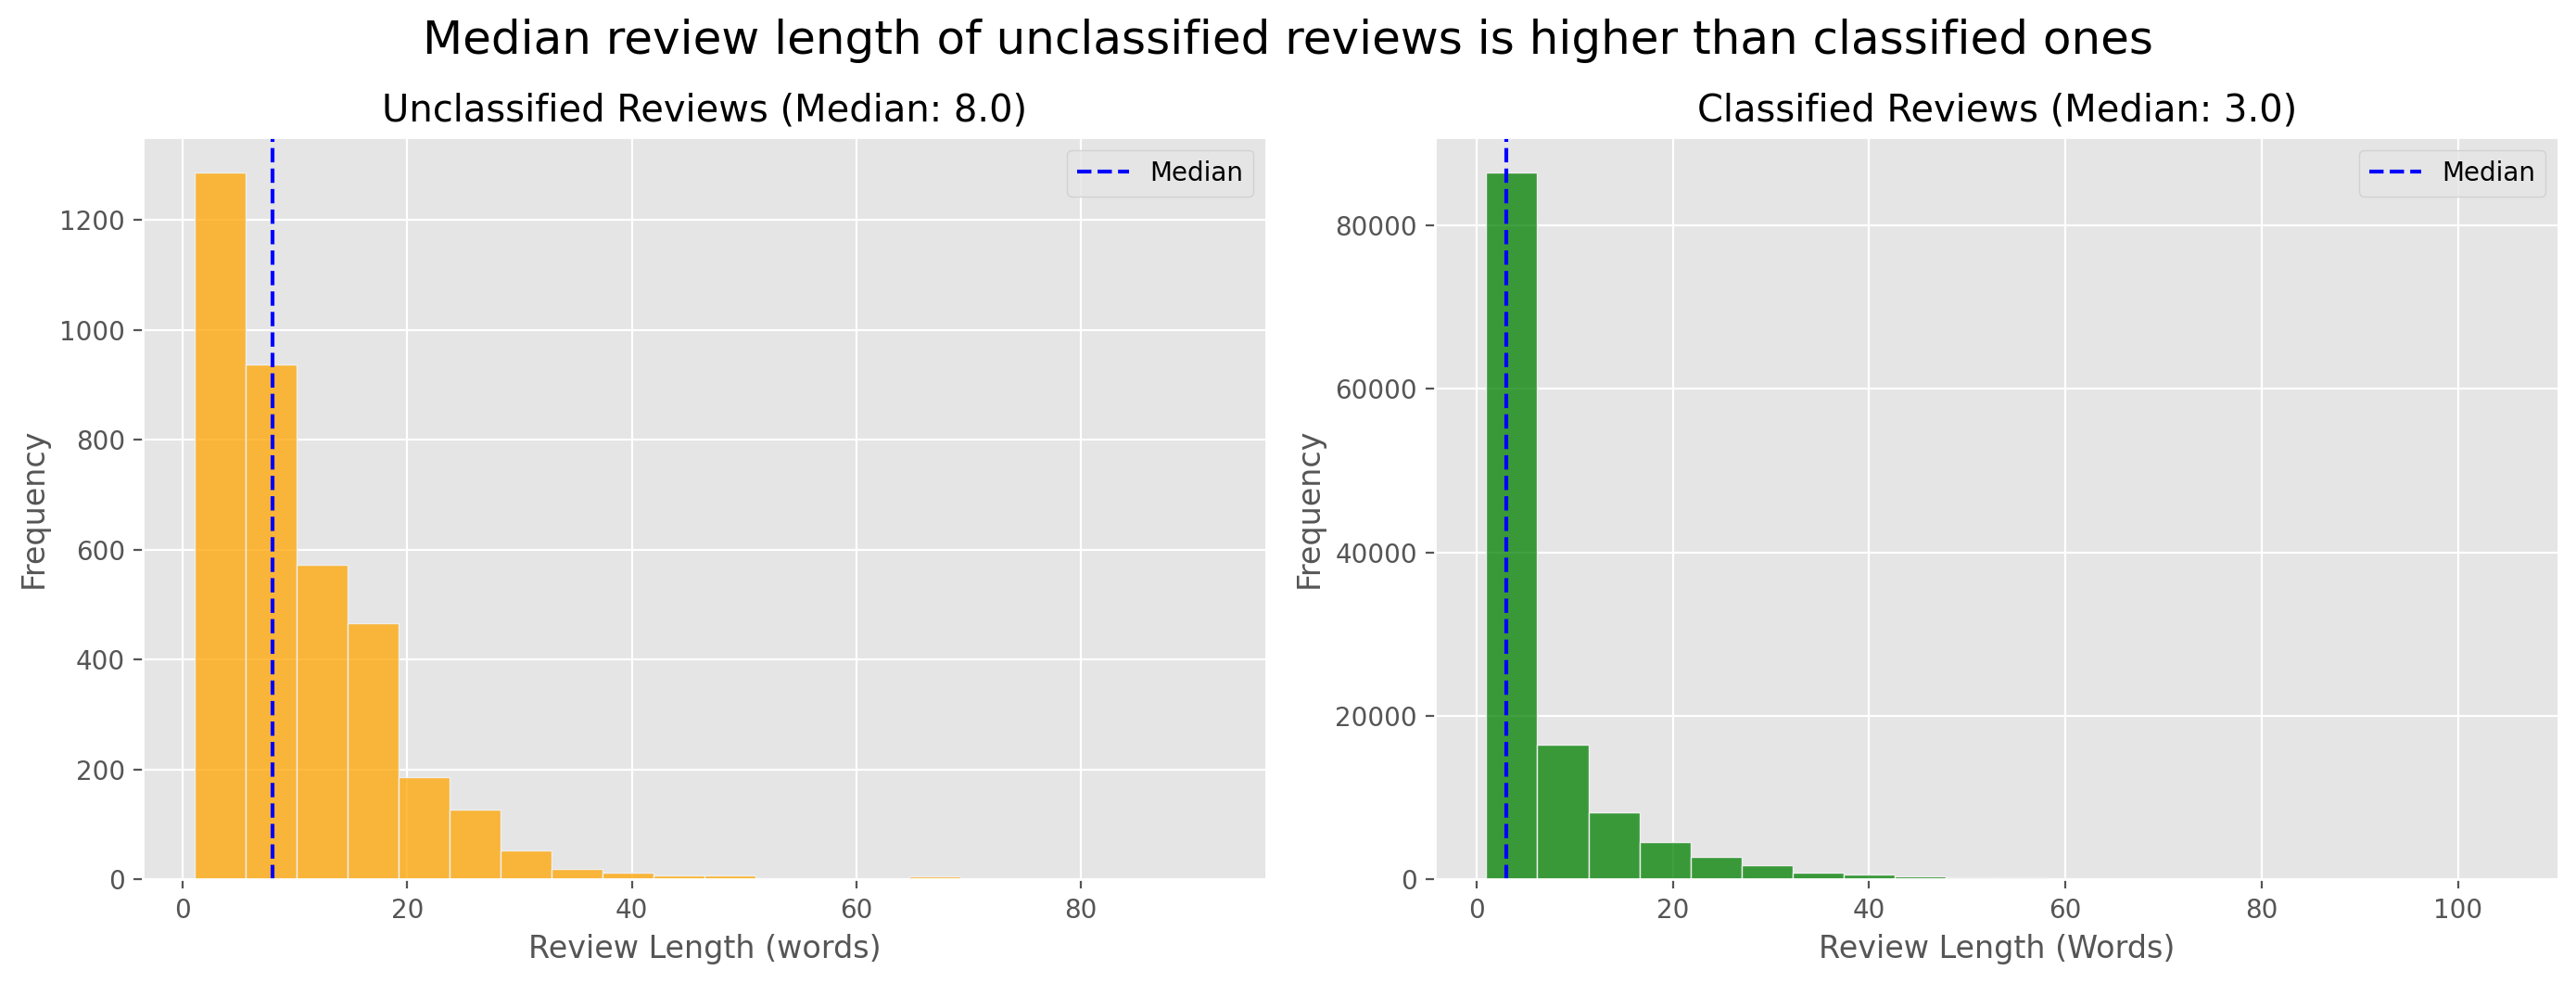

In [34]:
plt.figure(figsize=(14, 5), dpi=200)

# first subplot for unclassified reviews
median_unclassified = unclassified_ins['review_len'].median()
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(unclassified_ins['review_len'], bins=20, color='orange', kde=False)
plt.title(f'Unclassified Reviews (Median: {median_unclassified})')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.axvline(median_unclassified, color='blue', linestyle='--', label='Median')
plt.legend()

# second subplot for classified reviews
median_classified = df4['review_len'].median()
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df4['review_len'], bins=20, color='green', kde=False)
plt.title(f'Classified Reviews (Median: {median_classified})')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.axvline(median_classified, color='blue', linestyle='--', label='Median')
plt.legend()

plt.tight_layout()
plt.suptitle('Median review length of unclassified reviews is higher than classified ones', 
             y=1.05, size=18)
plt.show()

**Note**: Instead of too short, the unclassified reviews tend to be longer in words than classified ones. The median word length of unclassified reviews is 8 whereas the median length of classified ones is 3 words. This situation might imply that review length may not be the main reason for some instances not classified. Other factor than word length might lead to some reviews unclassified into any topics.

##### **4.5.3.2 Are there any overlapping topics?**

In [35]:
pd.options.display.max_colwidth=None

# extract the topics and their word distributions 
topics_data = tuned_lda_model.show_topics(formatted=False)

# prepare a list to store formatted topics
formatted_topics = []
for idx, topic in topics_data:
    formatted_topic = ', '.join([f"({word}, {weight:.2f})" for word, weight in topic])
    formatted_topics.append((idx, formatted_topic))

# create a df
topics_df = pd.DataFrame(formatted_topics, columns=['n_topic', 'top_words'])
display(topics_df)

,n_topic,top_words
0,0,"(gopay, 0.06), (aplikasi, 0.03), (top, 0.03), (saldo, 0.03), (udah, 0.02), (masuk, 0.02), (pake, 0.02), (up, 0.02), (banget, 0.02), (transfer, 0.01)"
1,1,"(bagus, 0.25), (mantap, 0.21), (good, 0.07), (aplikasi, 0.06), (aplikasinya, 0.03), (banget, 0.03), (mantab, 0.02), (gopay, 0.02), (nice, 0.01), (pokoknya, 0.01)"
2,2,"(membantu, 0.09), (gopay, 0.05), (aplikasi, 0.04), (bayar, 0.04), (pulsa, 0.01), (beli, 0.01), (pinjam, 0.01), (tagihan, 0.01), (transaksi, 0.01), (driver, 0.01)"
3,3,"(transfer, 0.09), (ribet, 0.04), (bank, 0.04), (gratis, 0.04), (mudah, 0.04), (aplikasi, 0.03), (gopay, 0.03), (gampang, 0.03), (biaya, 0.03), (admin, 0.02)"
4,4,"(mudah, 0.11), (aplikasi, 0.05), (transaksi, 0.05), (keren, 0.05), (cepat, 0.04), (kasih, 0.04), (gopay, 0.04), (aman, 0.03), (bintang, 0.03), (memudahkan, 0.03)"
5,5,"(aplikasi, 0.06), (gopay, 0.05), (semoga, 0.04), (kota, 0.03), (gojek, 0.02), (ringan, 0.02), (lancar, 0.02), (sukses, 0.02), (bertransaksi, 0.02), (simple, 0.01)"
6,6,"(ok, 0.12), (banget, 0.08), (suka, 0.03), (aplikasi, 0.03), (mempermudah, 0.02), (coba, 0.02), (bgt, 0.02), (lengkap, 0.02), (gopay, 0.02), (berguna, 0.02)"


In [36]:
# Get the top words for each topic
top_words_topic_0 = set([word for word, _ in lda_model.show_topic(0, topn=10)])
top_words_topic_2 = set([word for word, _ in lda_model.show_topic(2, topn=10)])
top_words_topic_5 = set([word for word, _ in lda_model.show_topic(5, topn=10)])

# Find the intersection between Topic 0, 2, and 5
intersection_words = top_words_topic_0 & top_words_topic_2 & top_words_topic_5
print(f"Common words between Topic 0, 2, and 5: {intersection_words}")

Common words between Topic 0, 2, and 5: {'aplikasi', 'gopay'}


**Note**
- Based on a formal inspection, there are some words found in multiple topics based on the topic distributions, especially for Topic 0, Topic 2, and Topic 5, in which *aplikasi* and *gopay* appear. The overlapping topics are actually normal. They indicate the centrality of *aplikasi* and *gopay* in the user reviews which has been indicated by Section 3.4.3 (first notebook). Previously, I demonstrated those words are among the most frequent terms in the user reviews, implying the central discussion of the reviews. 
- The shared terms across the three topics can also be further tested using cosine similarity.

In [37]:
# check topic overlap
word_topic_matrix = tuned_lda_model.get_topics()
similarity_matrix = cosine_similarity(word_topic_matrix)

# convert matrix to df
similarity_df = pd.DataFrame(similarity_matrix, 
                             columns=[f'Topic {i}' for i in range(similarity_matrix.shape[1])],
                             index=[f'Topic {i}' for i in range(similarity_matrix.shape[0])])

# display cosine similarity matrix
display(similarity_df.round(4).style.background_gradient(cmap='YlOrRd').format('{:.2f}'))

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Topic 0,1.00,0.10,0.39,0.34,0.23,0.46,0.20
Topic 1,0.10,1.00,0.08,0.07,0.08,0.12,0.08
Topic 2,0.39,0.08,1.00,0.19,0.22,0.38,0.11
Topic 3,0.34,0.07,0.19,1.00,0.33,0.24,0.08
Topic 4,0.23,0.08,0.22,0.33,1.00,0.30,0.09
Topic 5,0.46,0.12,0.38,0.24,0.30,1.00,0.16
Topic 6,0.20,0.08,0.11,0.08,0.09,0.16,1.00


**Note**: Cosine similarity is used to measure the extent to which different topics share similarities on the basis of word matrix (array) generated from LDA model (tuned). According to the dataframe of cosine similarity matrix, tThere is some evidence of overlapping topics, particularly between Topic 0, Topic 2, and Topic 5, which might indicate that these topics share common themes or words.

In [38]:
# use built-in LDA viz
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

**Note**
- The data visualization above includes intertopic distance map and bar chart for term relevance. First, intertopic distance map visualizes both prevalence of the topic in the model and distance between circles, representing how different topics are. Second, the bar chart displays terms ranked by their relevance. 
- There are some overlapping circles of different topics (Topic 4 and Topic 4; and Topic 1, 2, as well as 3), indicating similarity between these topics. The similarity between the topics is driven by the shared terms between them, i.e., *aplikasi* and *gojek*. As previously explained, the shared terms are normal since these terms represent the aboutness of the app user reviews.
- Since the size of the circles denotes the prevalence (relative importance) of the topic in the dataset, topic X is the most widespread topic. Previously, I showed that Topic 1 constituted 25.6% in the dataset.

#### **4.1.4 Topic Distributions over Time**

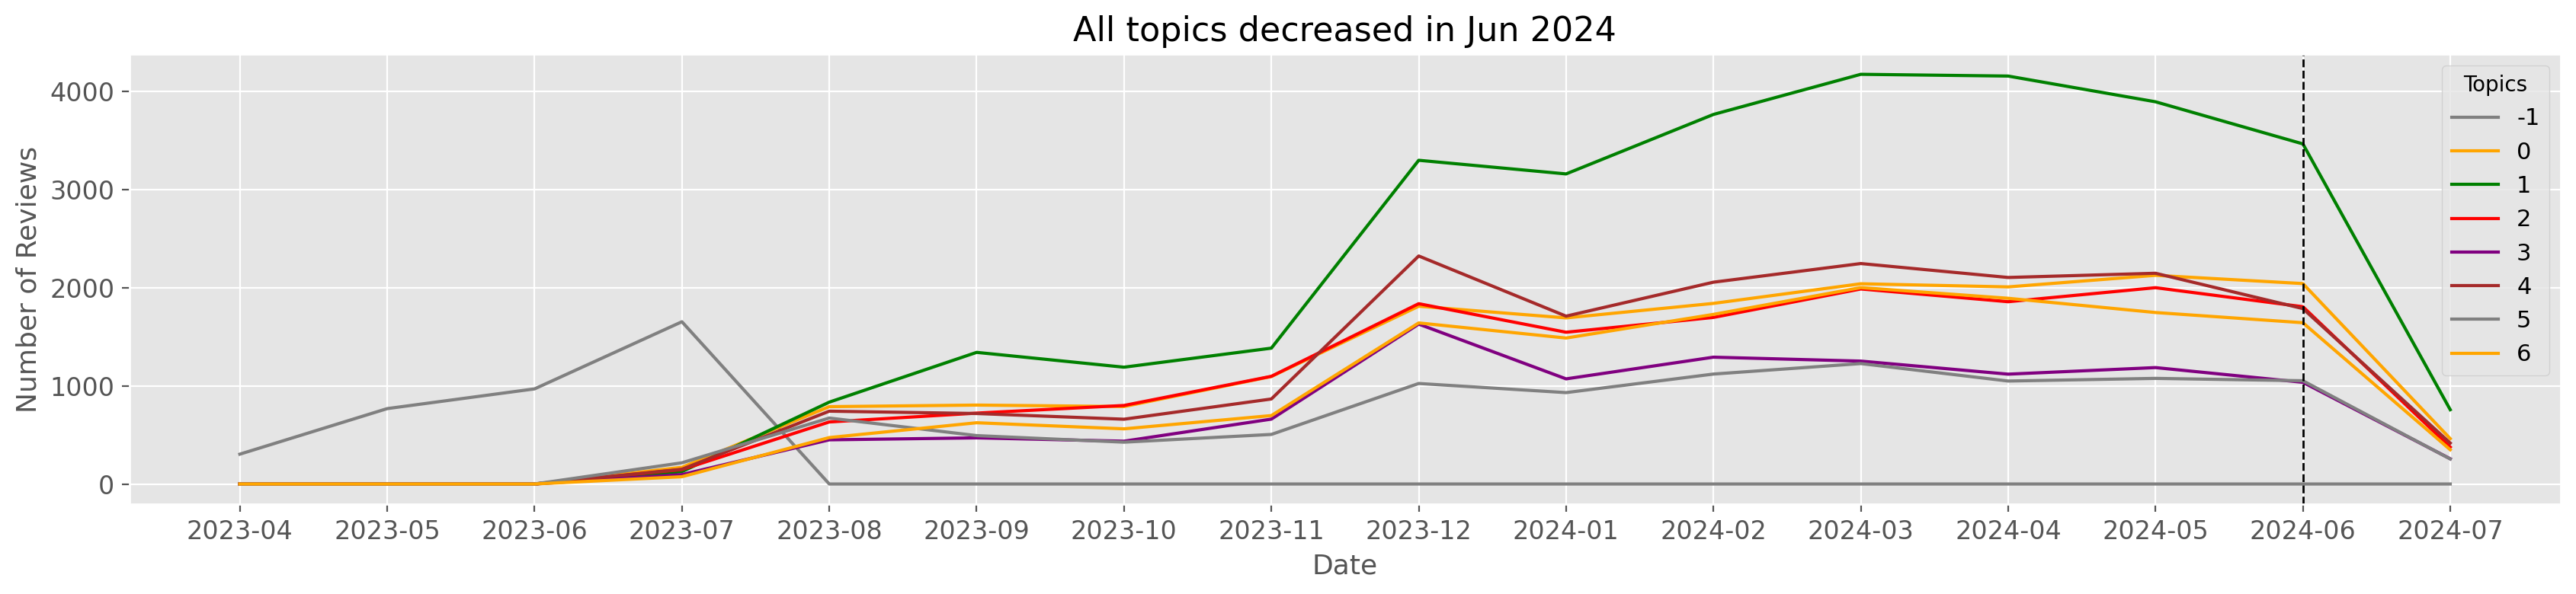

In [80]:
# prepare data
df4['year_month'] = df4['at'].dt.to_period('M').astype(str)
topic_trends = df4.groupby(['year_month', 'topic']).size().unstack(fill_value=0)

# plotting the trends
plt.figure(figsize=(17, 4), dpi=200)  
custom_palette = ['grey', 'orange', 'green', 'red', 'purple', 'brown']
line_styles = ['-', '-', '-', '-', '-', '-']

for idx, topic in enumerate(topic_trends.columns):
    sns.lineplot(data=topic_trends[topic],
                 color=custom_palette[idx % len(custom_palette)],
                 linestyle=line_styles[idx % len(line_styles)],
                 label=topic)

plt.axvline('2024-06', color='k', linestyle='--', linewidth=1)
# plt.legend(title='Topics', loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=12)  
plt.legend(title='Topics', loc='upper right', fontsize=11) 
plt.title('All topics decreased in Jun 2024', size=16)
plt.xlabel('Date', size=13)
plt.ylabel('Number of Reviews', size=13)
plt.xticks(rotation=0, size=12)
plt.yticks(size=12)
plt.grid(True)
plt.tight_layout() 
plt.show()

**Note**: The number of reviews containing all topics (classified ones) underwent drops in Jun 2024. The significant decrease was driven by the drop of overall number of reviews (see chart below) but it remains unknown why the number of reviews decreased in the first place. Here, I do not have any evidence from the dataset to explain the decline.

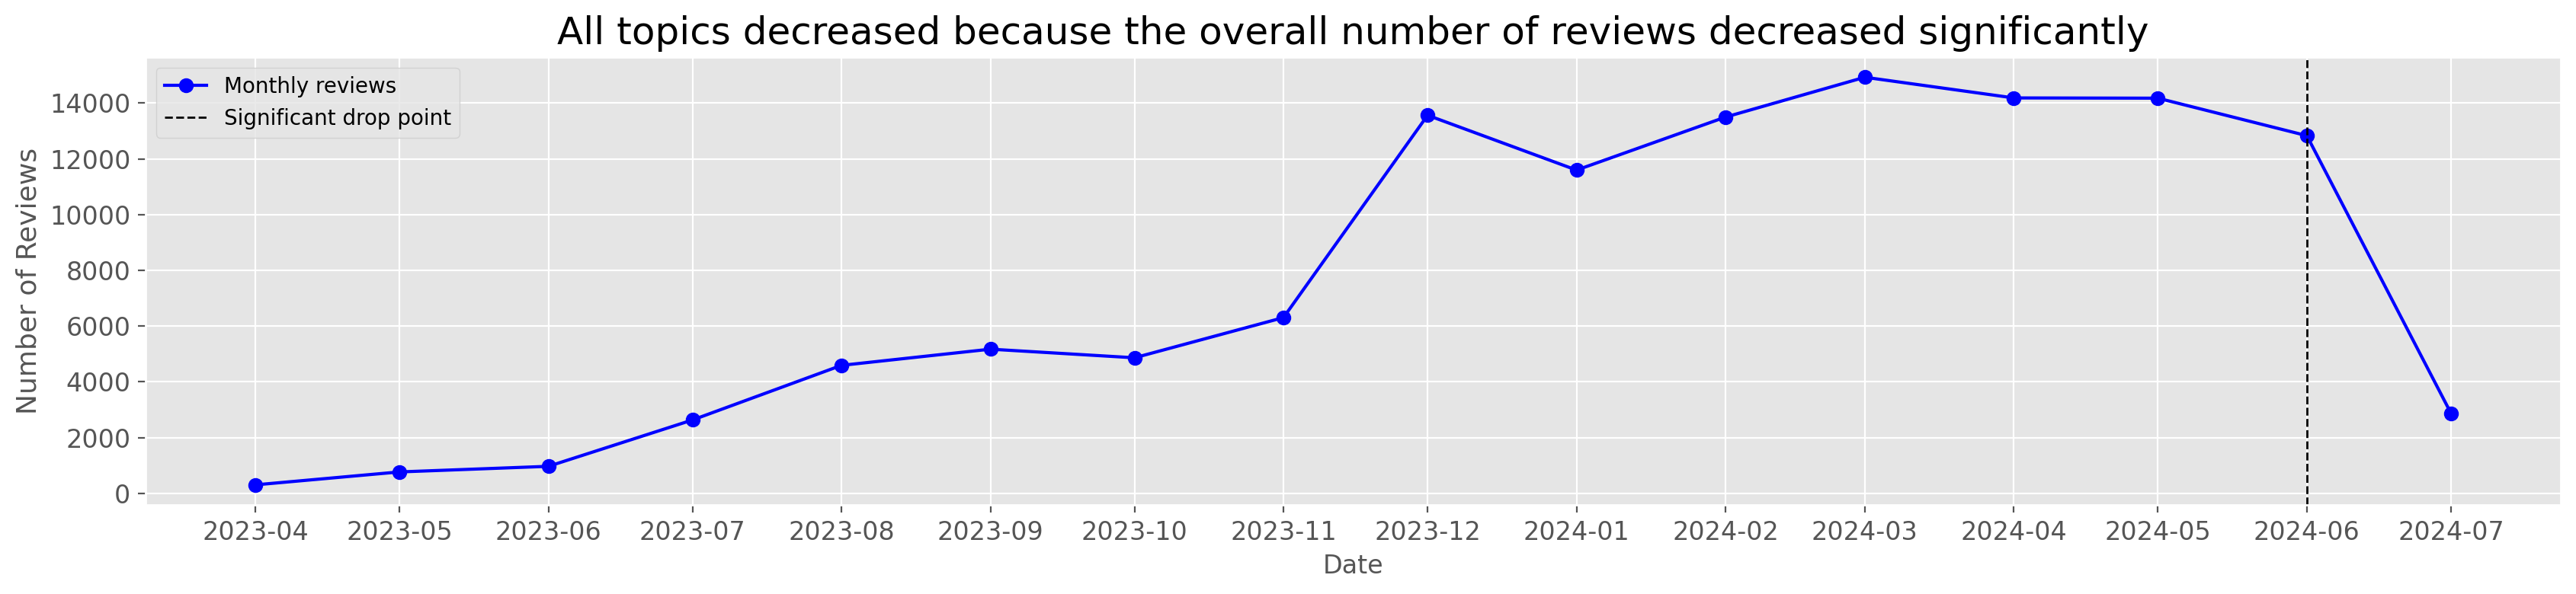

In [82]:
# prepare dataset
df4['year_month'] = pd.to_datetime(df4['year_month'])
monthly_reviews = df4.groupby(df4['year_month'].dt.to_period('M')).size()
monthly_reviews_new = monthly_reviews.reset_index(name='count')
monthly_reviews_new['year_month'] = monthly_reviews_new['year_month'].dt.to_timestamp()

# Plot number of reviews over time
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(monthly_reviews_new['year_month'], monthly_reviews_new['count'], marker='o', color='blue', label='Monthly reviews')

# Add a vertical line for the specified date (June 2024)
plt.axvline(x=pd.Timestamp('2024-06-01'), color='k', linestyle='--', linewidth=1, label='Significant drop point')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('All topics decreased because the overall number of reviews decreased significantly', size=18)
plt.xlabel('Date', size=12)
plt.ylabel('Number of Reviews', size=13)
plt.xticks(rotation=0, size=12)  
plt.yticks(size=12)
plt.grid(True)
# plt.legend(title='Legend', bbox_to_anchor=(1, 1), frameon=False) 
plt.legend()
plt.tight_layout()
plt.show()

#### **4.1.5 Cost-Benefit Analysis**
Previously, I have demonstrated how predictive modeling using Latent Dirichlet Allocation (LDA) is useful to extract key themes from a large body of a corpus. In general, the overall insight is positive perceptions about GoPay app regarding the features or usability. However, how much the automated topic extraction can help the Product Manager in saving cost has not been identified. Here, I attempt to perform a cost-benefit analysis via a simulation.

In order the simulation to work, there will be some assumptions or information. First, suppose that the topic extraction project is planned to finish from the extraction to the analysis in a month. Second, the project will involve either data scientists or human experts for extracting key themes on recurring terms or phrases. Syntactically speaking, key information of sentences is usually situated in the beginning of the sentence (see [topicalization](https://en.wikipedia.org/wiki/Topicalization)). Due to the in-depth nature of the qualitative approach by human experts (usually text annotator), the topic extraction will take days and a number of experts. Because the text size is enormous for a short-term project (*N* = 123253 rows in total) and suppose 30 days (8 hours of working) to accomplish. And time required for doing one row is approx 2 mins.
1. Calculate total time for the entire dataset. 
$$
\begin{align}
\text{Total time} &= N \times \text{Time per Annotation} = 123,253\\
&= \frac{123,253 \times 2}{60} \\
&= 41,008.4 \text{ hours}
\end{align}
$$
2. After obtaining the total time required, the estimated time per annotator will be:
$$\text{Total working hours per annotator} = 8 \times 30 = 240 \text{ hours}$$
3. Last, the min number of annotators will be needed for executing the project is $\approx$ 18 days.
$$
\begin{align}
\text{Total annotators} &= \frac{\text{Total time}}{\text{Total working hours per annotator}} \\
&= \frac{4108.43}{240} = 17.2
\end{align}
$$


In [35]:
# parameters
work_days_per_month = 30                    # working days
manual_time_days = 30                       # manual analysis time (in days)
manual_employees = 18                       # number of annotators
cost_per_month_annotator = 6500000          # monthly salary for each annotator
automated_time_days = 30                    # time for automated analysis in days
automated_employees = 2                     # number of data scientists
cost_per_month_data_scientist = 8000000     # monthly salary for each data scientist

# calculate cost
manual_total_cost = (cost_per_month_annotator / work_days_per_month) * manual_time_days * manual_employees
automated_total_cost = (cost_per_month_data_scientist / work_days_per_month) * automated_time_days * automated_employees

# cost comparison
cost_manual = manual_total_cost
cost_automated = automated_total_cost

# print results
print(f"Manual analysis total cost: Rp{manual_total_cost:.0f}")
print(f"Automated analysis total cost: Rp{automated_total_cost:.0f}")
print(f"Cost saved: Rp{manual_total_cost - automated_total_cost:.0f}")

Manual analysis total cost: Rp117000000
Automated analysis total cost: Rp16000000
Cost saved: Rp101000000


In [30]:
# function to format y-axis
def currency_format_millions(x, pos):
    return f'{x / 1_000_000:.0f}M'

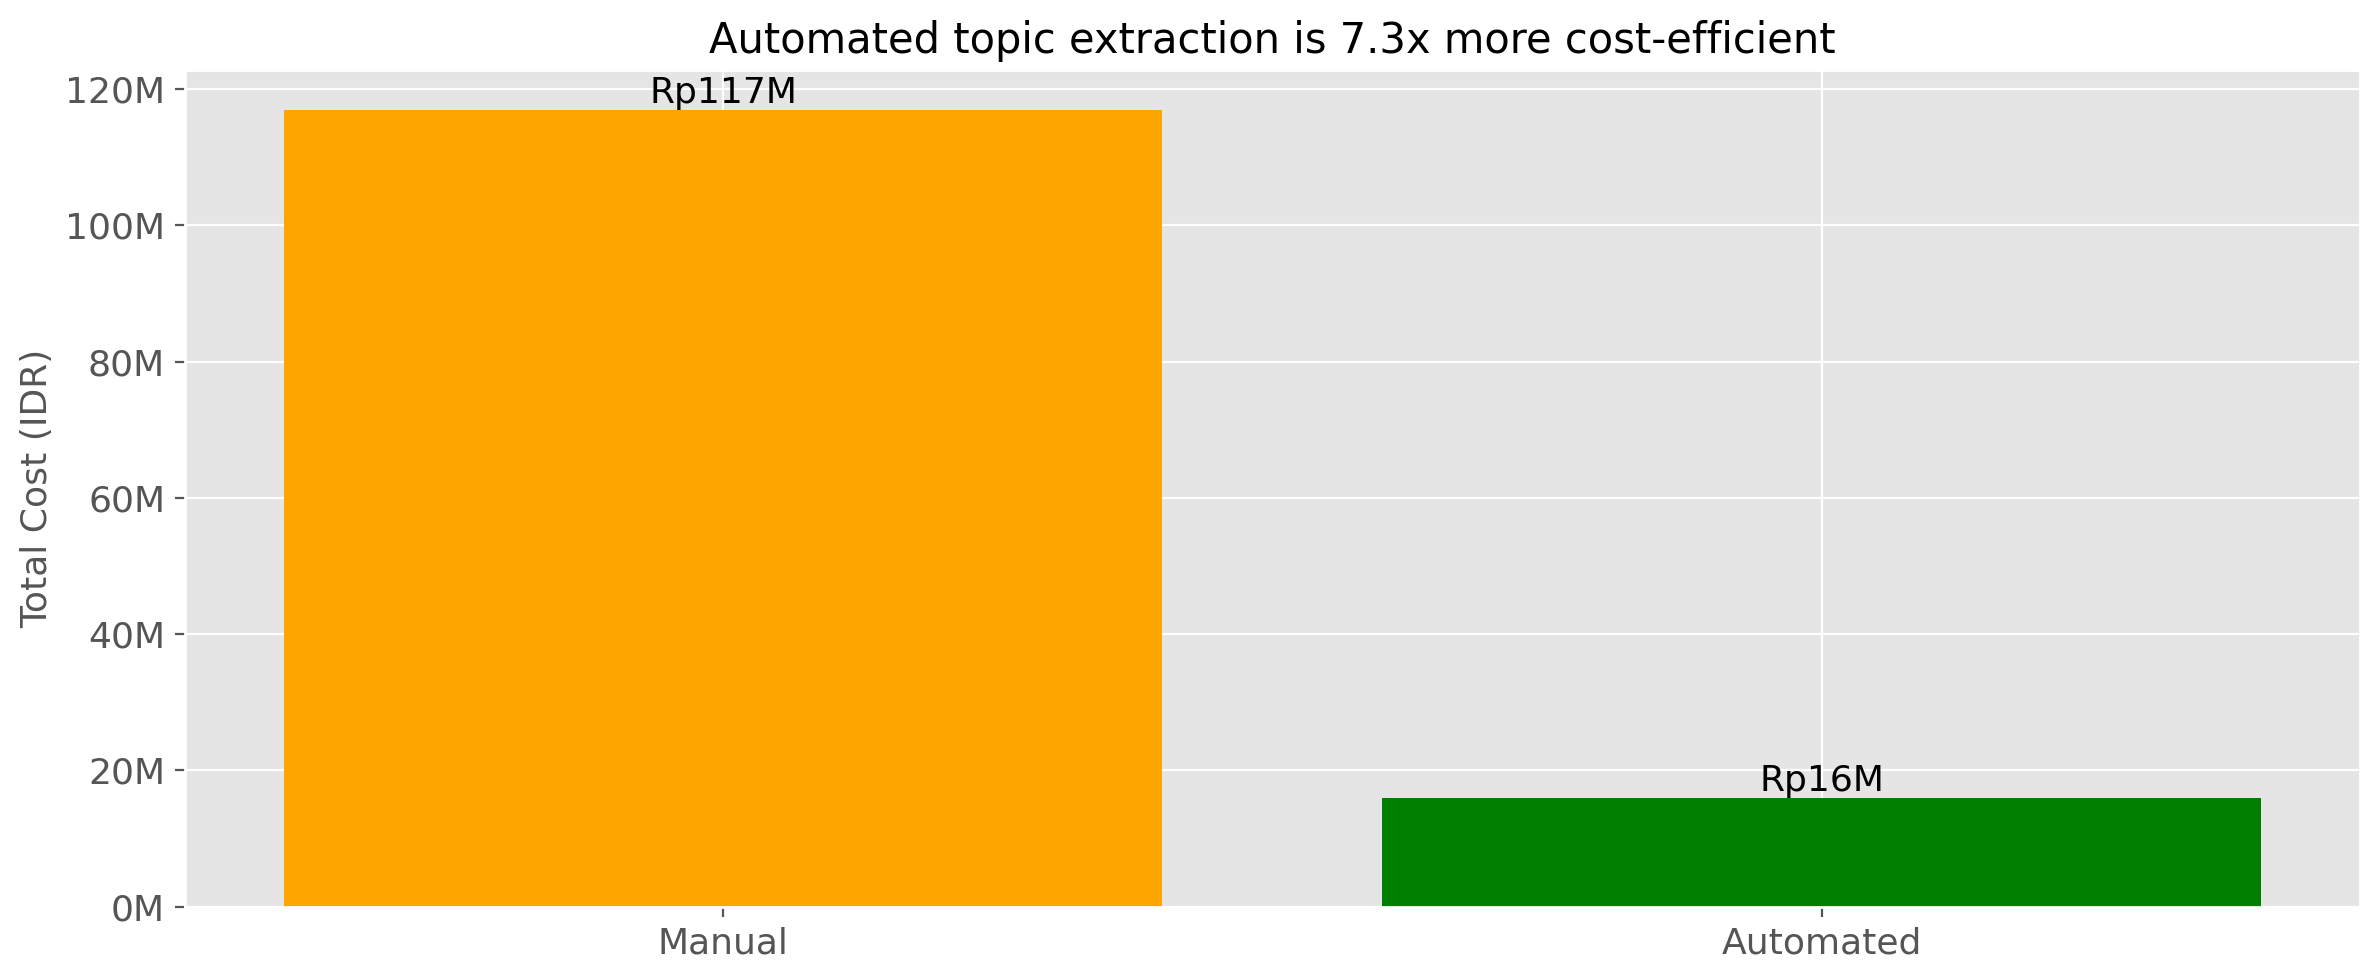

In [45]:
# cost comparison
labels = ['Manual', 'Automated']
costs = [manual_total_cost, automated_total_cost]

# create bar plot for cost comparison
plt.figure(figsize=(12, 5), dpi=200)
bars_cost = plt.bar(labels, costs, color=['orange', 'green'])
plt.title('Automated topic extraction is 7.3x more cost-efficient', size=15)
plt.ylabel('Total Cost (IDR)', size=13)
plt.xticks(size=13)
plt.yticks(size=13)

# apply currency formatting 
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format_millions))

# add data labels 
for bar in bars_cost:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'Rp{yval / 1_000_000:.0f}M', 
             ha='center', va='bottom', fontsize=13)

plt.tight_layout()
plt.show()

**Note**: Based on the simulation, the manual approach will approximately cost Rp117 millions for this particular project whereas the automated approach is 7.3 times more cost-efficient. The comparison means that the potential cost that can be saved is approx Rp101 millions.

### **4.6 Summary**

<h1 style='color:orange; text-align:center; font-weight:bold; font-style:italic'>--Move on to Notebook 3--</h1>

In [83]:
# save model
joblib.dump(tuned_lda_model, '../model/lda_model.pkl')
print('LDA model has been successfully saved!')

LDA model has been successfully saved!
